<a href="https://colab.research.google.com/github/vahab-mspour/Amazon_Products_Sentiment_Analysis/blob/master/R_BERT_Keras_v1_6_blstm_realTestData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

README:

This Notebook is edited version of [BERT_Keras_v1_4_multi_lstm_f1_86268_edited_with_chebi_path.ipynb](https://colab.research.google.com/drive/1frk36GOto6MCRVk54Hn4akOHZNlrgiit?authuser=1) to apply on ddi2013_realTestDataset

In v1_4_multi_lstm_f1_86268 we tested on sampled testdata from train_df and got f1 score = 0.86268 ==0.863

Project Sourse Blog [Link](https://www.section.io/engineering-education/natural-language-processing-using-tensorflow-and-bert-model/)

[link?](https://www.section.io/engineering-education/natural-language-processing-using-tensorflow-and-bert-model/)

Notebook of prepairing **train_df** vahabmspourtez: [chebi_path_notebook_v2.ipynb](https://colab.research.google.com/drive/1Wy75JSaj46VewMAByYOuZM11Raf0kGE8?authuser=1#scrollTo=DAz0pB9-0Tlx&uniqifier=3) 

Notebook of prepairing **test_df** vahabmspourtez/srd_ddi: [chebi_path_notebook_v3.ipynb](https://drive.google.com/file/d/1GL4znquHWO_iENX_Nl6DeTsID1zsbHfh/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install Datasets

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf

import pandas as pd

In [ ]:
# Get GPU device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

SystemError: ignored

In [ ]:
!nvidia-smi

##DDI2013 Dataset

###**Load DDI Train Data DF**



In [ ]:
#@title **Load** Completed **Train_df** with Text Sents only
import pandas as pd
train_csv_file_path = "/content/drive/MyDrive/Colab Notebooks/Bert_Sample_Data/ddi_train_data_with_drug_name.csv"#ddi_train_data_with_drugs_index.csv"
train_df = pd.read_csv(train_csv_file_path, delimiter='@')
print(len(train_df))
train_df.head(3)

26383


,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,middlepart,after
0,false,0,Laboratory Tests Response to DRUGA_3268 should...,Plenaxis,testosterone,DRUGA_3268,DRUGB_1506,3268,1506,Laboratory Tests Response to,should be monitored by measuring serum total,concentrations just prior to administration o...
1,false,0,Population pharmacokinetic analyses revealed t...,MTX,NSAIDs,DRUGA_513,DRUGB_882,513,882,Population pharmacokinetic analyses revealed t...,",",", monoamine oxidase (MAO) inhibitors623 , and..."
2,false,0,Population pharmacokinetic analyses revealed t...,MTX,corticosteroids,DRUGA_513,DRUGB_2623,513,2623,Population pharmacokinetic analyses revealed t...,", lactulose82 ,",", and monoamine oxidase (MAO) inhibitors22 di..."


In [ ]:
#@title **Load** Completed **Train_df** with **common_ascestors** and **synonyms**
import json
train_json_file_path = "/content/drive/MyDrive/Colab Notebooks/Bert_Sample_Data/"
train_df = pd.read_json(train_json_file_path+"ddi_train_data_with_drug_name_and_common_ancestors.json")# chebi_path_notebook_v2.ipynb also active in chebi_path_notebook_v3.ipynb
print(len(train_df))
train_df.head(3)

26383


,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,middlepart,after,common_ascestors_ssm,leftpath,rightpath,chebi_syns_drugA,chebi_syns_drugB
0,false,0,Laboratory Tests Response to DRUGA_3268 should...,Plenaxis,testosterone,DRUGA_3268,DRUGB_1506,3268,1506,Laboratory Tests Response to,should be monitored by measuring serum total,concentrations just prior to administration o...,"[polycyclic compound, organic cyclic compound,...","[penams, beta-lactam antibiotic, beta-lactam, ...","[testosterone, C19-steroid, 17beta-hydroxy ste...","[Eraxis, penams, Plexiglas, Levaxin, Pentasa, ...","[testosterone, TESTOSTERONE, Testosterone, Tes..."
1,false,0,Population pharmacokinetic analyses revealed t...,MTX,NSAIDs,DRUGA_513,DRUGB_882,513,882,Population pharmacokinetic analyses revealed t...,",",", monoamine oxidase (MAO) inhibitors623 , and...",[],"[methotrexate, pteridines, dicarboxylic acid, ...","[non-steroidal anti-inflammatory drug, anti-in...","[MTX, MTX3, MT, Mt, MTX 3, MTX-3, CMX, MTT, CT...","[NSAIDs, NSAID, Ansaid, acids, enamides, ynami..."
2,false,0,Population pharmacokinetic analyses revealed t...,MTX,corticosteroids,DRUGA_513,DRUGB_2623,513,2623,Population pharmacokinetic analyses revealed t...,", lactulose82 ,",", and monoamine oxidase (MAO) inhibitors22 di...","[polycyclic compound, organic cyclic compound,...","[methotrexate, pteridines, dicarboxylic acid, ...","[corticosteroid, steroid, organic polycyclic c...","[MTX, MTX3, MT, Mt, MTX 3, MTX-3, CMX, MTT, CT...","[corticosteroids, corticosteroides, corticoste..."


In [ ]:
#@title **Load** Completed **Test_df** with **common_ascestors** and **synonyms**
import json
import pandas as pd
test_json_file_path = "/content/drive/MyDrive/Colab Notebooks/Bert_Sample_Data/"
test_df  = pd.read_json(test_json_file_path+"ddi_test_data_with_drug_name_and_common_ancestors.json")# generated in chebi_path_notebook_v3.ipynb
print(len(test_df))
test_df.head(3)

5415


,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,middlepart,after,common_ascestors_ssm,leftpath,rightpath,chebi_syns_drugA,chebi_syns_drugB
0,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,were not altered by the addition of either,or monoamine oxidase (MAO) inhibitors736 or t...,"[organic heterocyclic compound, heterocyclic c...","[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a..."
1,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,zidovudine,DRUGA_2289,DRUGB_2736,2289,2736,Pharmacokinetic properties of,were not altered by the addition of either ri...,or the combination of rimantadine HCl492 and ...,"[heteroarene, organic aromatic compound, aroma...","[abacavir, 2,6-diaminopurines, aminopurine, pu...","[zidovudine, pyrimidine 2',3'-dideoxyribonucle...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[zidovudine, Zidovudin, Zidovudinum, idoxuridi..."
2,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,were not altered by the addition of either ri...,and monoamine oxidase (MAO) inhibitors736 .,"[organic heterocyclic compound, heterocyclic c...","[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a..."


In [ ]:
#@title ontology pathes from list to text
def onto_pathes_from_list_to_text(df):
  import numpy as np
  common_ascestors = []
  common_ascestors_ssm_col = df['common_ascestors_ssm']
  for ls in common_ascestors_ssm_col:
    if len(ls)<1:
      common_ascestors.append(np.NaN)
      #print(np.NaN)
    else:
      chebi_ca = " ".join([node for node in ls ]) 
      common_ascestors.append(chebi_ca)
      #print(chebi_ca)
  return common_ascestors

train_df["common_ascestors_ssm"] = onto_pathes_from_list_to_text(train_df) 

test_df["common_ascestors_ssm"] = onto_pathes_from_list_to_text(test_df) 
test_df.head(3)

,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,middlepart,after,common_ascestors_ssm,leftpath,rightpath,chebi_syns_drugA,chebi_syns_drugB
0,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,were not altered by the addition of either,or monoamine oxidase (MAO) inhibitors736 or t...,organic heterocyclic compound heterocyclic com...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a..."
1,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,zidovudine,DRUGA_2289,DRUGB_2736,2289,2736,Pharmacokinetic properties of,were not altered by the addition of either ri...,or the combination of rimantadine HCl492 and ...,heteroarene organic aromatic compound aromatic...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[zidovudine, pyrimidine 2',3'-dideoxyribonucle...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[zidovudine, Zidovudin, Zidovudinum, idoxuridi..."
2,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,were not altered by the addition of either ri...,and monoamine oxidase (MAO) inhibitors736 .,organic heterocyclic compound heterocyclic com...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a..."


In [ ]:
SEP = [" [SEP] " for i in range(len(train_df))]
train_df["middle"] = train_df["drugA_text"]+ SEP + train_df["middlepart"]+ SEP + train_df["drugB_text"]
train_df.head(3)

,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,middlepart,after,common_ascestors_ssm,leftpath,rightpath,chebi_syns_drugA,chebi_syns_drugB,middle
0,false,0,Laboratory Tests Response to DRUGA_3268 should...,Plenaxis,testosterone,DRUGA_3268,DRUGB_1506,3268,1506,Laboratory Tests Response to,should be monitored by measuring serum total,concentrations just prior to administration o...,polycyclic compound organic cyclic compound cy...,"[penams, beta-lactam antibiotic, beta-lactam, ...","[testosterone, C19-steroid, 17beta-hydroxy ste...","[Eraxis, penams, Plexiglas, Levaxin, Pentasa, ...","[testosterone, TESTOSTERONE, Testosterone, Tes...",Plenaxis [SEP] should be monitored by measuri...
1,false,0,Population pharmacokinetic analyses revealed t...,MTX,NSAIDs,DRUGA_513,DRUGB_882,513,882,Population pharmacokinetic analyses revealed t...,",",", monoamine oxidase (MAO) inhibitors623 , and...",NaN,"[methotrexate, pteridines, dicarboxylic acid, ...","[non-steroidal anti-inflammatory drug, anti-in...","[MTX, MTX3, MT, Mt, MTX 3, MTX-3, CMX, MTT, CT...","[NSAIDs, NSAID, Ansaid, acids, enamides, ynami...","MTX [SEP] , [SEP] NSAIDs"
2,false,0,Population pharmacokinetic analyses revealed t...,MTX,corticosteroids,DRUGA_513,DRUGB_2623,513,2623,Population pharmacokinetic analyses revealed t...,", lactulose82 ,",", and monoamine oxidase (MAO) inhibitors22 di...",polycyclic compound organic cyclic compound cy...,"[methotrexate, pteridines, dicarboxylic acid, ...","[corticosteroid, steroid, organic polycyclic c...","[MTX, MTX3, MT, Mt, MTX 3, MTX-3, CMX, MTT, CT...","[corticosteroids, corticosteroides, corticoste...","MTX [SEP] , lactulose82 , [SEP] corticosteroids"


In [ ]:
SEP = [" [SEP] " for i in range(len(test_df))]
test_df["middle"] = test_df["drugA_text"]+ SEP + test_df["middlepart"]+ SEP + test_df["drugB_text"]
test_df.head(3)

,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,middlepart,after,common_ascestors_ssm,leftpath,rightpath,chebi_syns_drugA,chebi_syns_drugB,middle
0,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,were not altered by the addition of either,or monoamine oxidase (MAO) inhibitors736 or t...,organic heterocyclic compound heterocyclic com...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a...",abacavir [SEP] were not altered by the additi...
1,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,zidovudine,DRUGA_2289,DRUGB_2736,2289,2736,Pharmacokinetic properties of,were not altered by the addition of either ri...,or the combination of rimantadine HCl492 and ...,heteroarene organic aromatic compound aromatic...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[zidovudine, pyrimidine 2',3'-dideoxyribonucle...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[zidovudine, Zidovudin, Zidovudinum, idoxuridi...",abacavir [SEP] were not altered by the additi...
2,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,were not altered by the addition of either ri...,and monoamine oxidase (MAO) inhibitors736 .,organic heterocyclic compound heterocyclic com...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a...",abacavir [SEP] were not altered by the additi...


In [ ]:
train_df["befor"] = train_df["befor"].fillna("")
train_df["after"] = train_df["after"].fillna("")
train_df["common_ascestors_ssm"] = train_df["common_ascestors_ssm"].fillna(" ")
#train_df.head(3)

In [ ]:
test_df["befor"] = test_df["befor"].fillna("")
test_df["after"] = test_df["after"].fillna("")
test_df["common_ascestors_ssm"] = test_df["common_ascestors_ssm"].fillna(" ")
#test_df.head(3)

##Bio-Bert Tokenizer
1. from transformers import BertModel
2. download and unzip 'biobert_v1.1_pubmed'
3. bio_model = BertModel.from_pretrained('biobert_v1.1_pubmed')

###Downloading the main BioBERT file
Here we are downloading the main BioBERT file, extracting the BioBERT weights, and converting them to be applicable in PyTorch so as to work with the HuggingFace API. We move the config file for simplicity, and now are good to go!

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt

--2022-11-19 12:44:43--  https://docs.google.com/uc?export=download&confirm=t&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD
Resolving docs.google.com (docs.google.com)... 74.125.202.138, 74.125.202.101, 74.125.202.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.202.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/89c95thhe083ihhd5uuvnb0kl9fhk7ud/1668861825000/13799006341648886493/*/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download&uuid=ef49b884-dc91-48ce-91fe-83531966a6ce [following]
--2022-11-19 12:44:44--  https://doc-10-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/89c95thhe083ihhd5uuvnb0kl9fhk7ud/1668861825000/13799006341648886493/*/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download&uuid=ef49b884-dc91-48ce-91fe-83531966a6ce
Resolving doc-10-20-docs.googleusercontent.com (doc-10-20-docs.googleusercontent.com)... 172.217.214.132,

In [ ]:
!tar -xzf biobert_weights
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.index  vocab.txt
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta


In [ ]:
# conver tensorflow pretrain model to pytorch
!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

In [ ]:
!ls biobert_v1.1_pubmed/
!mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt
config.json				model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt


In [ ]:
!ls

biobert_v1.1_pubmed  biobert_weights  drive  sample_data


###preprocess ddi dataset seperate to sentence parts#initialize these parameters:


In [ ]:
X_input_ids_0 = np.zeros((len(train_df), 60))
X_attn_masks_0 = np.zeros((len(train_df), 60))

X_input_ids_1 = np.zeros((len(train_df), 60))
X_attn_masks_1 = np.zeros((len(train_df), 60))

X_input_ids_2 = np.zeros((len(train_df), 60))
X_attn_masks_2 = np.zeros((len(train_df), 60))

labels = np.zeros((len(train_df), 5))

#ontology channel inputs
X_input_ids_3 = np.zeros((len(train_df), 60))
X_attn_masks_3 = np.zeros((len(train_df), 60))

print("labels.shape=",labels.shape)
print("X_input_ids_1.shape=",X_input_ids_1.shape)
print(X_input_ids_1[0])

print("X_input_ids_0.shape=",X_input_ids_0.shape)
print(X_input_ids_0[0])
print("X_input_ids_3.shape=",X_input_ids_3.shape)
print(X_input_ids_3[0])

In [ ]:
#@title Performing one-hot encoding
labels[np.arange(len(train_df)), list(train_df['label'])]
y = list(train_df['label'])
labels = tf.keras.utils.to_categorical(y , num_classes=5, dtype='float32')
labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
def preprocessing_dataset(df, ids, masks, tokenizer,sen_part='middle'):
    for i, text in tqdm(enumerate(df[sen_part])):
      tokenized_text = tokenizer.encode_plus(
          text,
          max_length=60, 
          truncation=True, 
          padding='max_length', 
          add_special_tokens=True,
          return_tensors='tf'
          )
      ids[i, :] = tokenized_text.input_ids
      masks[i, :] = tokenized_text.attention_mask

    return ids, masks

In [ ]:
#@title preprocessing_onto_dataset_OLD
def preprocessing_onto_dataset_0(df, ids, masks, tokenizer,path_part='common_ascestors_ssm'):
    for i, path in tqdm(enumerate(df[path_part])):
      text = "".join([e for e in  path])
      #print(text)
      tokenized_text = tokenizer.encode_plus(
          text,
          max_length=60, 
          truncation=True, 
          padding='max_length', 
          add_special_tokens=True,
          return_tensors='tf'
          )
      ids[i, :] = tokenized_text.input_ids
      masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
#@title preprocessing_onto_dataset_OLD_2
def preprocessing_onto_dataset_1(df, ids, masks, tokenizer,path_part='common_ascestors_ssm'):
    for i, path_text in tqdm(enumerate(df[path_part])):
      tokenized_text = tokenizer.encode_plus(
          path_text,
          max_length=60, 
          truncation=True, 
          padding='max_length', 
          add_special_tokens=True,
          return_tensors='tf'
          )
      ids[i, :] = tokenized_text.input_ids
      masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
#@title Bio-Bert Tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed')

In [ ]:
train_df.columns

Index(['ddi', 'label', 'sentence_text', 'drugA_text', 'drugB_text', 'drugA',
       'drugB', 'drugA_drugindex', 'drugB_drugindex', 'befor', 'middlepart',
       'after', 'common_ascestors_ssm', 'leftpath', 'rightpath',
       'chebi_syns_drugA', 'chebi_syns_drugB', 'middle'],
      dtype='object')

In [ ]:
X_input_ids_0, X_attn_masks_0 = preprocessing_dataset(train_df, X_input_ids_0, X_attn_masks_0, tokenizer, sen_part='befor')


0it [00:00, ?it/s]

In [ ]:
X_input_ids_1, X_attn_masks_1 = preprocessing_dataset(train_df, X_input_ids_1, X_attn_masks_1, tokenizer, sen_part='middle')


0it [00:00, ?it/s]

In [ ]:
X_input_ids_2, X_attn_masks_2 = preprocessing_dataset(train_df, X_input_ids_2, X_attn_masks_2, tokenizer, sen_part='after')

0it [00:00, ?it/s]

In [ ]:
#ontology path input
X_input_ids_3, X_attn_masks_3 = preprocessing_dataset(train_df, X_input_ids_3, X_attn_masks_3, tokenizer,sen_part='common_ascestors_ssm')#path_part='common_ascestors_ssm')

0it [00:00, ?it/s]

In [ ]:
print("labels.shape=",labels.shape)
print("X_input_ids_1.shape=",X_input_ids_1.shape)
print(X_input_ids_1[0])
print("X_input_ids_0.shape=",X_input_ids_0.shape)
print(X_input_ids_0[0])
print("X_input_ids_3.shape=",X_input_ids_3.shape)
print(X_input_ids_3[0])


labels.shape= (26383, 5)
X_input_ids_1.shape= (26383, 60)
[  101.   185. 23675.  8745.  1116.   102.  1431.  1129. 19232.  1118.
 10099. 23651.  1703.   102.  2774. 26622.   102.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
X_input_ids_0.shape= (26383, 60)
[ 101. 8087. 5715. 2593. 1106.  102.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
X_input_ids_3.shape= (26383, 60)
[  101.   185. 23415.  3457.  1665.  8031.  7090.  7878.   172. 24974.
  7090.   17

In [ ]:
#@title Sents Sampels:
print(train_df["befor"][0:3])
print()
text_ =train_df["befor"][3] 
print("input_ids , attention_mask: \n")
print(tokenizer.encode_plus(text_).input_ids)
print(tokenizer.encode_plus(text_).attention_mask)
print("\nX_input_ids_befor[0:1]: \n", X_input_ids_0[0:2])
#print("-----ontology--")
print("\nX_input_ids_1[0:1]: \n", X_input_ids_1[0:2])
print("=========================")

0                        Laboratory Tests Response to 
1    Population pharmacokinetic analyses revealed t...
2    Population pharmacokinetic analyses revealed t...
Name: befor, dtype: object

input_ids , attention_mask: 

[101, 1416, 185, 7111, 1918, 2528, 4314, 9265, 18460, 3090, 1115, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

X_input_ids_befor[0:1]: 
 [[  101.  8087.  5715.  2593.  1106.   102.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [  101.  1416.   185.  7111.  1918.  2528.  4314.  9265. 18460.  3090.
   1115.   102.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0. 

In [ ]:
#@title Ontology Sampels
print("-----ontology--")
print("\nX_input_ids_ontology[0:1]: \n", X_input_ids_3[0:3])
print("=========================")

-----ontology--

X_input_ids_ontology[0:1]: 
 [[  101.   185. 23415.  3457.  1665.  8031.  7090.  7878.   172. 24974.
   7090.   172. 24974.  7090.  5677.  5658. 16844.  4915.  7090.  5677.
   9962.  1348.  2528.  4915.  7090.  7621.  9546.  9127.  7878. 14730.
  14730. 22572.  1348.  2528.  4915.  9546.  9127.  1119. 25710.  1766.
   3820.  1596.  9127.   185. 23415. 10024.  7257.  9127.  7878.  9546.
   9127.  6302.  1372.  9546.  9127.   185.   118.  3510.  9546.   102.]
 [  101.   102.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [  101.   185. 23415.  3457.  1665.  8031.  7090.  7878.   172. 24974.
   7090.   172. 

In [ ]:
#@title **test inputs**
X_test_input_ids_0 = np.zeros((len(test_df), 60))
X_test_attn_masks_0 = np.zeros((len(test_df), 60))

X_test_input_ids_1 = np.zeros((len(test_df), 60))
X_test_attn_masks_1 = np.zeros((len(test_df), 60))

X_test_input_ids_2 = np.zeros((len(test_df), 60))
X_test_attn_masks_2 = np.zeros((len(test_df), 60))

#ontology channel inputs
X_test_input_ids_3 = np.zeros((len(test_df), 60))
X_test_attn_masks_3 = np.zeros((len(test_df), 60))

#label
test_labels = np.zeros((len(test_df), 5))

print("test_labels.shape=",test_labels.shape)
print("X_test_input_ids_0.shape=",X_test_input_ids_1.shape)
print(X_input_ids_1[0])

print("X_test_input_ids_0.shape=",X_test_input_ids_0.shape)
print(X_test_input_ids_0[0])

test_labels.shape= (5415, 5)
X_test_input_ids_0.shape= (5415, 60)
[  101.   185. 23675.  8745.  1116.   102.  1431.  1129. 19232.  1118.
 10099. 23651.  1703.   102.  2774. 26622.   102.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
X_test_input_ids_0.shape= (5415, 60)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
#@title Performing one-hot encoding - **test_labels**
test_labels[np.arange(len(test_df)), list(test_df['label'])]
test_y = list(test_df['label'])
test_labels = tf.keras.utils.to_categorical(test_y , num_classes=5, dtype='float32')
test_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
X_test_input_ids_0, X_test_attn_masks_0 = preprocessing_dataset(test_df, X_test_input_ids_0, X_test_attn_masks_0, tokenizer, sen_part='befor')

0it [00:00, ?it/s]

In [ ]:
X_test_input_ids_1, X_test_attn_masks_1 = preprocessing_dataset(test_df, X_test_input_ids_1, X_test_attn_masks_1, tokenizer, sen_part='middle')

0it [00:00, ?it/s]

In [ ]:
X_test_input_ids_2, X_test_attn_masks_2 = preprocessing_dataset(test_df, X_test_input_ids_2, X_test_attn_masks_2, tokenizer, sen_part='after')

0it [00:00, ?it/s]

In [ ]:
#onto
X_test_input_ids_3, X_test_attn_masks_3 = preprocessing_dataset(test_df, X_test_input_ids_3, X_test_attn_masks_3, tokenizer, sen_part='common_ascestors_ssm')

0it [00:00, ?it/s]

###Train- Test Data Method-1 ,  **Vahab Datasets methods**

In [ ]:
from datetime import date
print(str(date.today()))

2022-11-17


In [ ]:
#@title Select/Generate TEST_SET_INDEXES
ORIGINAL_TEST_DATASET = "ORIGINAL_TEST_DATASET"
FROM_SAVED_JSON = "FROM_SAVED_JSON"
CREATE_RANDOM_TEST_SET_INDEXES = "CREATE_RANDOM_TEST_SET_INDEXES"
test_set_inedxes = ORIGINAL_TEST_DATASET #@param ["ORIGINAL_TEST_DATASET", "FROM_SAVED_JSON", "CREATE_RANDOM_TEST_SET_INDEXES"] {type:"raw"}

print("test_set_inedxes= ",test_set_inedxes)
import json
import random
from datetime import date

if test_set_inedxes == ORIGINAL_TEST_DATASET:
  random_test_indexs=np.array([])
  print("Selected original ddi2013extraction dataset- test_dataset, not selected indexes")
if test_set_inedxes == FROM_SAVED_JSON:
  with open('/content/drive/MyDrive/Colab Notebooks/model_/test_set_random_indexes.json', 'r') as json_f:
    random_test_indexs = json.load(json_f)
    print(random_test_indexs)

if test_set_inedxes == CREATE_RANDOM_TEST_SET_INDEXES:
    random_test_indexs = list(set(random.sample(range(0, len(X_input_ids_1)), int(len(X_input_ids_1)*0.3))))#Create random indexes for test data selection...
    with open("/content/drive/MyDrive/Colab Notebooks/model_/test_set_random_indexes"+str(date.today())+".json", 'w') as json_f:
      json.dump(random_test_indexs, json_f, indent = 6)
    json_f.close()

test_set_inedxes=  ORIGINAL_TEST_DATASET
Selected original ddi2013extraction dataset- test_dataset, not selected indexes


In [ ]:
print(len(random_test_indexs))

0


In [ ]:

#Generate 5 random numbers between 10 and 30
#randomlist = random.sample(range(10, 30), 5)
#print(X_input_ids.shape)
#random_test_indexs =np.array(random_test_indexs)
train_indexs = np.array([i for i in range(len(X_input_ids_1)) if i not in random_test_indexs])
print(random_test_indexs)

#======================train========================
train_X_input_ids_0 = X_input_ids_0[train_indexs]
train_X_attn_masks_0 = X_attn_masks_0[train_indexs]

train_X_input_ids_1 = X_input_ids_1[train_indexs]
train_X_attn_masks_1 = X_attn_masks_1[train_indexs]

train_X_input_ids_2 = X_input_ids_2[train_indexs]
train_X_attn_masks_2 = X_attn_masks_2[train_indexs]

train_labels = labels[train_indexs]
#onto
train_X_input_ids_3 = X_input_ids_3[train_indexs]
train_X_attn_masks_3 = X_attn_masks_3[train_indexs]
#======================test========================
#======test dataset from original ddi2013-test======

if len(random_test_indexs) == 0:
  test_X_input_ids_0 = X_test_input_ids_0 
  test_X_attn_masks_0 = X_test_attn_masks_0

  test_X_input_ids_1 = X_test_input_ids_1 
  test_X_attn_masks_1 = X_test_attn_masks_1

  test_X_input_ids_2 = X_test_input_ids_2 
  test_X_attn_masks_2 = X_test_attn_masks_2

  test_labels = test_labels

  #onto
  test_X_input_ids_3 = X_test_input_ids_3 
  test_X_attn_masks_3 = X_test_attn_masks_3 
#======================test from train dataset==== 
if len(random_test_indexs) > 0:
  test_X_input_ids_0 = X_input_ids_0[random_test_indexs]
  test_X_attn_masks_0 = X_attn_masks_0[random_test_indexs]

  test_X_input_ids_1 = X_input_ids_1[random_test_indexs]
  test_X_attn_masks_1 = X_attn_masks_1[random_test_indexs]


  test_X_input_ids_2 = X_input_ids_2[random_test_indexs]
  test_X_attn_masks_2 = X_attn_masks_2[random_test_indexs]

  test_labels = train_labels[random_test_indexs]

  #onto
  test_X_input_ids_3 = X_input_ids_3[random_test_indexs]
  test_X_attn_masks_3 = X_attn_masks_3[random_test_indexs]

#=====================y_true=====================
y_true = np.argmax(test_labels,axis=1)
print("train_shapes")
print(train_X_input_ids_1.shape)
print(train_X_attn_masks_1.shape)
print(train_labels.shape)
print("test_shapes")
print(test_X_input_ids_1.shape)
print(test_X_attn_masks_1.shape)
print(test_labels.shape)
print(len(y_true))
print(y_true[0:60])

[]
train_shapes
(26383, 60)
(26383, 60)
(26383, 5)
test_shapes
(5415, 60)
(5415, 60)
(5415, 5)
5415
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 2 0 0 0 3 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 0 0]


###Seperated Datasets like dataset_0, dataset_1, dataset_2

In [ ]:
import tensorflow as tf
  
# using tf.data.Dataset.from_tensor_slices() method
#gfg1 = tf.data.Dataset.from_tensor_slices(([5, 10], [3, 6], [5, 10]))

dataset_1 = tf.data.Dataset.range(10, 20)
dataset_2 = tf.data.Dataset.range(60, 70)

combined_dataset = dataset_1.concatenate(dataset_2)
combined_dataset
"""
for ele in combined_dataset:
    print(ele.numpy())
"""
import tensorflow as tf

a = tf.zeros((100,4,8))
b = tf.ones((100,4,8))

d1 = tf.data.Dataset.from_tensor_slices(a)
d1 = d1.batch(16,drop_remainder=True)      # elements shape (16,4,8)

d2 = tf.data.Dataset.from_tensor_slices(b)
d2 = d2.batch(16,drop_remainder=True)      # elements shape (16,4,8)

d = tf.data.Dataset.zip((d1,d2))
d = d.map(lambda x,y:tf.stack([x,y],axis=-1)) # elements shape (16,4,8,2)

it = iter(d)
x = next(it)
print(x.shape)
print(x)

(16, 4, 8, 2)
tf.Tensor(
[[[[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]]


 [[[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]]


 [[[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]]


 ...


 [[[0. 1.]
   [0. 1.]
   [0. 1.]
   ...
   [0. 1.]
   [0. 1.]


In [ ]:
print(train_X_input_ids_0.shape)
print(train_X_attn_masks_1.shape)

(26383, 60)
(26383, 60)


In [ ]:
dataset_0 = tf.data.Dataset.from_tensor_slices((train_X_input_ids_0, train_X_attn_masks_0))
dataset_1 = tf.data.Dataset.from_tensor_slices((train_X_input_ids_1, train_X_attn_masks_1))
dataset_2 = tf.data.Dataset.from_tensor_slices((train_X_input_ids_2, train_X_attn_masks_2, train_labels))

In [ ]:
dataset_1

<TensorSliceDataset element_spec=(TensorSpec(shape=(60,), dtype=tf.float64, name=None), TensorSpec(shape=(60,), dtype=tf.float64, name=None))>

In [ ]:
#dataset = tf.data.Dataset.from_tensor_slices((train_X_input_ids_0, train_X_attn_masks_0, train_X_input_ids_1, train_X_attn_masks_1, train_X_input_ids_2, train_X_attn_masks_2, train_labels))

### Single Dataset with separated dict keys 

In [ ]:
print(train_X_input_ids_0.shape)
print(train_X_attn_masks_1.shape)
print(train_X_attn_masks_3.shape)

(26383, 60)
(26383, 60)
(26383, 60)


In [ ]:
print(test_X_input_ids_0.shape)
print(test_X_attn_masks_1.shape)

(5415, 60)
(5415, 60)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((train_X_input_ids_0, train_X_attn_masks_0, train_X_input_ids_1, train_X_attn_masks_1,train_X_input_ids_2, train_X_attn_masks_2,train_X_input_ids_3, train_X_attn_masks_3, train_labels))
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(60,), dtype=tf.float64, name=None), TensorSpec(shape=(60,), dtype=tf.float64, name=None), TensorSpec(shape=(60,), dtype=tf.float64, name=None), TensorSpec(shape=(60,), dtype=tf.float64, name=None), TensorSpec(shape=(60,), dtype=tf.float64, name=None), TensorSpec(shape=(60,), dtype=tf.float64, name=None), TensorSpec(shape=(60,), dtype=tf.float64, name=None), TensorSpec(shape=(60,), dtype=tf.float64, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))>

In [ ]:
#@title Creating a map function

#initialize the map function
def DDIDatasetMapFunction(input_ids_0, attn_masks_0, input_ids_1, attn_masks_1,input_ids_2, attn_masks_2, input_ids_3, attn_masks_3, labels):
    return {
        'input_ids_0': input_ids_0,
        'attention_mask_0': attn_masks_0,

        'input_ids_1': input_ids_1,
        'attention_mask_1': attn_masks_1,

        'input_ids_2': input_ids_2,
        'attention_mask_2': attn_masks_2,

        'input_ids_3': input_ids_3,
        'attention_mask_3': attn_masks_3
    }, labels


In [ ]:
#@title Apply Map Function on train-dataset
#call the map function
dataset = dataset.map(DDIDatasetMapFunction)

#Shuffling the training dataset
dataset = dataset.shuffle(5000).batch(16, drop_remainder=True) 
#dataset = dataset.batch(16, drop_remainder=True) 
print("number of batches:",len(dataset))

number of batches: 1648


In [ ]:
#@title Defining the training dataset train 0.85, validation 0.15
p = 0.90
train_size = int((len(train_labels)//16)*p)
print("train_size=",train_size)
training_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)
#training_dataset.take(1)

train_size= 1483


In [ ]:
print(len(training_dataset))

1483


In [ ]:
#del train_df
#del dataset
#training_dataset.shape

In [ ]:
#@title Default test_dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_X_input_ids_0, test_X_attn_masks_0, test_X_input_ids_1, test_X_attn_masks_1,test_X_input_ids_2, test_X_attn_masks_2,test_X_input_ids_3, test_X_attn_masks_3, test_labels))

test_dataset = test_dataset.map(DDIDatasetMapFunction)
test_dataset = test_dataset.batch(16, drop_remainder=True) 
#test_dataset = test_dataset.shuffle(5000).batch(16, drop_remainder=True) 
#test_dataset.take(1)

In [ ]:
#print(list(test_dataset.as_numpy_iterator())[0:2][1][0])# shows 1th batch of 2 batches: data list(test_dataset.as_numpy_iterator())[batch_list][batch_index][0=input_id and attn dict, 1= labels]

In [ ]:
"""
print(len(test_dataset))
"""
for i in dataset:
  print(i)
  break
#"""

In [ ]:
test_input_ids_ = list(test_dataset.as_numpy_iterator())[0:][0][0]['input_ids_0']
test_attn_mask_ = list(test_dataset.as_numpy_iterator())[0:2][0][0]['attention_mask_0']
test_labels_ = list(test_dataset.as_numpy_iterator())[0:2][0][1]
test_labels_
#test_input_ids

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
batch_test_labels = list(test_dataset.as_numpy_iterator())[0:][2][1]
print(len(batch_test_labels))
print(batch_test_labels[0:20])

16
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


###get **y_true** from test_dataset

In [ ]:
#@title get **y_true** from test_dataset 329x16 = 5264
all_test_baches_list = list(test_dataset.as_numpy_iterator())[0:]
print(len(all_test_baches_list))
test_labels_dict = {}
for i in range(len(test_dataset)):
  batch_test_labels = all_test_baches_list[i][1]
  for j in range(len(batch_test_labels)):
    val = batch_test_labels[j]
    test_labels_dict.update({(i,j):(np.argmax(val),val)})
    #print(i, "-",j,"-", "- ",val,"-", np.argmax(val))

y_true = [v[0] for k, v in test_labels_dict.items()]
print(len(y_true))
print(y_true[0:60])
print(np.argmax(test_labels, axis=1)[0:60])

338
5408
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 2 0 0 0 3 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 0 0]


Number of relation types in the test data: Counter({0: 4437, 2: 359, 1: 299, 3: 221, 4: 92})



(array([4437.,    0.,  299.,    0.,    0.,  359.,    0.,  221.,    0.,
          92.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

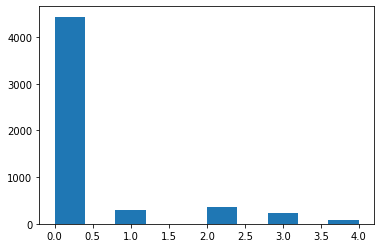

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

print("Number of relation types in the test data:", Counter(y_true))
print()
plt.hist(y_true)

In [ ]:
#@title get **y_tain** from training_dataset 329x16 = 5264
all_train_baches_list = list(training_dataset.as_numpy_iterator())[0:]
print(len(all_train_baches_list))
train_labels_dict = {}
for i in range(len(training_dataset)):
  batch_train_labels = all_train_baches_list[i][1]
  for j in range(len(batch_train_labels)):
    val = batch_train_labels[j]
    train_labels_dict.update({(i,j):(np.argmax(val),val)})
    #print(i, "-",j,"-", "- ",val,"-", np.argmax(val))

y_train = [v[0] for k, v in train_labels_dict.items()]
print(len(y_train))
print(y_train[0:60])
print(np.argmax(train_labels, axis=1)[0:60])

1483
23728
[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Number of relation types in the train data: Counter({0: 20124, 2: 1498, 1: 1187, 3: 743, 4: 176})



(array([20124.,     0.,  1187.,     0.,     0.,  1498.,     0.,   743.,
            0.,   176.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

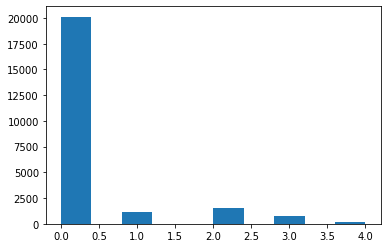

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

print("Number of relation types in the train data:", Counter(y_train))
print()
plt.hist(y_train)

###Prepair DDI dataset Method 2

##Bert-Model_Creation

In [ ]:
#@title Third-party Jupyter widgets
from google.colab import output
output.enable_custom_widget_manager()
"============================================"
from google.colab import output
output.disable_custom_widget_manager()

#soure:
#https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=-zTqxvNYbgZU

In [ ]:
from transformers import TFBertModel

In [ ]:
bio_model = TFBertModel.from_pretrained('biobert_v1.1_pubmed', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [ ]:
##@title  Adding the Input layers
input_ids_0 = tf.keras.layers.Input(shape=(60,), name='input_ids_0', dtype='int32')
attn_masks_0 = tf.keras.layers.Input(shape=(60,), name='attention_mask_0', dtype='int32')

input_ids_1 = tf.keras.layers.Input(shape=(60,), name='input_ids_1', dtype='int32')
attn_masks_1 = tf.keras.layers.Input(shape=(60,), name='attention_mask_1', dtype='int32')

input_ids_2 = tf.keras.layers.Input(shape=(60,), name='input_ids_2', dtype='int32')
attn_masks_2 = tf.keras.layers.Input(shape=(60,), name='attention_mask_2', dtype='int32')


#Ontology
input_ids_3 = tf.keras.layers.Input(shape=(60,), name='input_ids_3', dtype='int32')
attn_masks_3 = tf.keras.layers.Input(shape=(60,), name='attention_mask_3', dtype='int32')

In [ ]:
#@title with **H-BLSTM**  **f1=0.7119** :(

#bio-bert layer
#bert_embds = bio_model.bert(input_ids, attention_mask=attn_masks)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

bert_hidden_state_0 = bio_model.bert(input_ids_0, attention_mask=attn_masks_0)[0]
bert_hidden_state_1 = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[0]
bert_hidden_state_2 = bio_model.bert(input_ids_2, attention_mask=attn_masks_2)[0]

bert_embds = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

#LSTMs
"""
lstm_0 = tf.keras.layers.LSTM(768,  dropout=0.2)(bert_hidden_state_0)
lstm_1 = tf.keras.layers.LSTM(768,  dropout=0.2)(bert_hidden_state_1)
lstm_2 = tf.keras.layers.LSTM(768,  dropout=0.2)(bert_hidden_state_2)

concatenate_layer = tf.keras.layers.concatenate([lstm_0, lstm_1, lstm_2], axis=1)
print(concatenate_layer.shape)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(concatenate_layer)
""" 


#BLSTMs
blstm_0 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_0)
blstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_1)
blstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_2)

concatenate_layer = tf.keras.layers.concatenate([blstm_0, blstm_1, blstm_2], axis=1)
print(concatenate_layer.shape)
#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(concatenate_layer)#(lstm_1)#(bert_embds)



blstm_l2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768,  dropout=0.2))(concatenate_layer)#(blstm_1)###(100, return_sequences=True, dropout=0.2)(bert_hidden_state_1)
#https://datascience.stackexchange.com/questions/76444/how-can-i-build-a-self-attention-model-with-tf-keras-layers-attention
#attention = tf.keras.layers.Attention(use_scale=True)(lstm_1, lstm_1)#  use_scale=True arg: that is a scaling of the self-attention tensor
# intermediate layers
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(blstm_l2)#(concatenate_layer)#(lstm_1)#(bert_embds)

#output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) 

(None, 180, 1536)


In [ ]:
#@title with **LSTMs and Ontology** 

#bio-bert layer
#bert_embds = bio_model.bert(input_ids, attention_mask=attn_masks)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

bert_hidden_state_0 = bio_model.bert(input_ids_0, attention_mask=attn_masks_0)[0]
bert_hidden_state_1 = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[0]
bert_hidden_state_2 = bio_model.bert(input_ids_2, attention_mask=attn_masks_2)[0]

#ontology 
bert_hidden_state_3 = bio_model.bert(input_ids_3, attention_mask=attn_masks_3)[0]
#-----
bert_embds = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

#LSTMs

lstm_0 = tf.keras.layers.LSTM(768,  dropout=0.25)(bert_hidden_state_0)
lstm_1 = tf.keras.layers.LSTM(768,  dropout=0.25)(bert_hidden_state_1)
lstm_2 = tf.keras.layers.LSTM(768,  dropout=0.25)(bert_hidden_state_2)

lstm_onto = tf.keras.layers.LSTM(768,  dropout=0.25)(bert_hidden_state_3)
print(lstm_onto)
concatenate_layer = tf.keras.layers.concatenate([lstm_0, lstm_1, lstm_2, lstm_onto], axis=1)
print(concatenate_layer.shape)
#intermediate_layer
intermediate_layer = tf.keras.layers.Dense(786, activation='relu', name='intermediate_layer')(concatenate_layer)#512

"""
#BLSTMs
blstm_0 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_0)
blstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_1)
blstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_2)

concatenate_layer = tf.keras.layers.concatenate([blstm_0, blstm_1, blstm_2], axis=1)
print(concatenate_layer.shape)


blstm_l2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768,  dropout=0.2))(concatenate_layer)#(blstm_1)###(100, return_sequences=True, dropout=0.2)(bert_hidden_state_1)
#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(blstm_l2)#(concatenate_layer)#(lstm_1)#(bert_embds)
"""

#https://datascience.stackexchange.com/questions/76444/how-can-i-build-a-self-attention-model-with-tf-keras-layers-attention
#attention = tf.keras.layers.Attention(use_scale=True)(lstm_1, lstm_1)#  use_scale=True arg: that is a scaling of the self-attention tensor


#output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) 

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='lstm_8/PartitionedCall:0', description="created by layer 'lstm_8'")
(None, 3072)


In [ ]:
#@title with **H-BLSTM** 

#bio-bert layer
#bert_embds = bio_model.bert(input_ids, attention_mask=attn_masks)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

bert_hidden_state_0 = bio_model.bert(input_ids_0, attention_mask=attn_masks_0)[0]
bert_hidden_state_1 = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[0]
bert_hidden_state_2 = bio_model.bert(input_ids_2, attention_mask=attn_masks_2)[0]

bert_embds = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

#LSTMs

lstm_0 = tf.keras.layers.LSTM(768,  dropout=0.2)(bert_hidden_state_0)
lstm_1 = tf.keras.layers.LSTM(768,  dropout=0.2)(bert_hidden_state_1)
lstm_2 = tf.keras.layers.LSTM(768,  dropout=0.2)(bert_hidden_state_2)

concatenate_layer = tf.keras.layers.concatenate([lstm_0, lstm_1, lstm_2], axis=1)
print(concatenate_layer.shape)
#intermediate_layer
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(concatenate_layer)

"""
#BLSTMs
blstm_0 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_0)
blstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_1)
blstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_2)

concatenate_layer = tf.keras.layers.concatenate([blstm_0, blstm_1, blstm_2], axis=1)
print(concatenate_layer.shape)


blstm_l2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768,  dropout=0.2))(concatenate_layer)#(blstm_1)###(100, return_sequences=True, dropout=0.2)(bert_hidden_state_1)
#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(blstm_l2)#(concatenate_layer)#(lstm_1)#(bert_embds)
"""

#https://datascience.stackexchange.com/questions/76444/how-can-i-build-a-self-attention-model-with-tf-keras-layers-attention
#attention = tf.keras.layers.Attention(use_scale=True)(lstm_1, lstm_1)#  use_scale=True arg: that is a scaling of the self-attention tensor


#output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) 

(None, 2304)


In [ ]:
#@title with/without lstm layers
#bio-bert layer
bert_embds = bio_model.bert(input_ids, attention_mask=attn_masks)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 
bert_hidden_state =  bio_model.bert(input_ids, attention_mask=attn_masks)[0]
print("pooler_output=",bert_embds.shape)
print("last_hidden_state=",bert_hidden_state.shape)
# intermediate layers
"""
reshaped = tf.reshape(bert_embds,(16,768,1))
print(reshaped.shape)
"""

blstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_1)

lstm_1 = tf.keras.layers.LSTM(768,  dropout=0.2)(blstm_1)#(bert_embds)#return_sequences=True,
print(lstm_1.shape)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(lstm_1)#(bert_embds)

#output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) 

pooler_output= (None, 768)
last_hidden_state= (None, 60, 768)
(None, 768)


In [ ]:
#@title without lstm layers
#bio-bert layer
bert_embds = bio_model.bert(input_ids, attention_mask=attn_masks)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

#to see only
bert_hidden_state =  bio_model.bert(input_ids, attention_mask=attn_masks)[0]
# intermediate layers
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

#output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) 

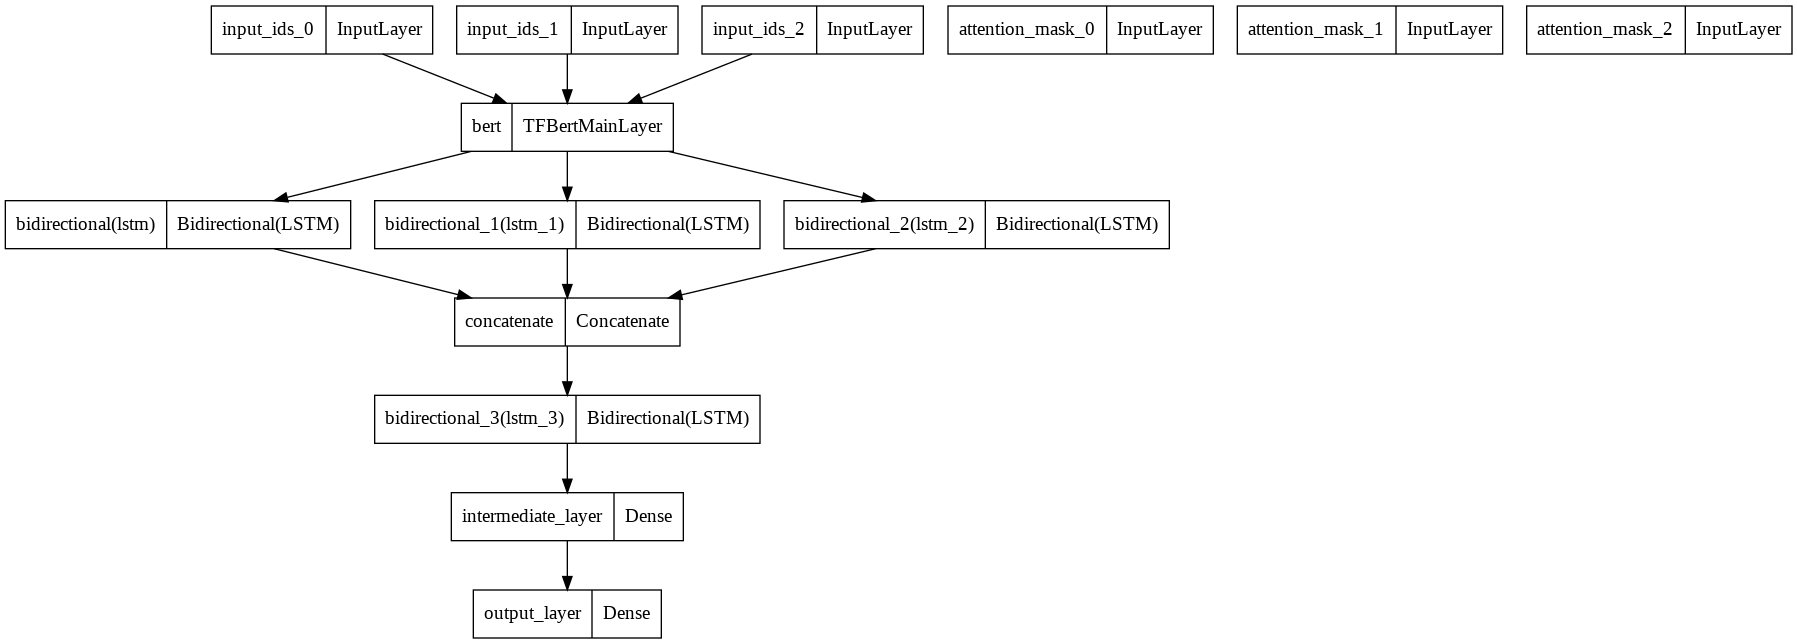

In [ ]:
#@title hblstm f1=0.7119 :(
import keras
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
plot_model(ddi_model, to_file='/content/sample_data/ddi_model_with_hbltsm_.png')


In [ ]:
print(bert_hidden_state_1)
lstm_1_ = tf.keras.layers.LSTM(768,  dropout=0.4)(bert_hidden_state_1)#512
lstm_1_

KerasTensor(type_spec=TensorSpec(shape=(None, 60, 768), dtype=tf.float32, name=None), name='bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'bert'")


<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'lstm_4')>

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert/     Step4:build
bert_embds[:, 0, :]

###**ddi_model_onto**; ddi_model **with ontology** f1=0.842

In [ ]:
#model with ontology 
ddi_model_onto = tf.keras.Model(inputs=[input_ids_0, attn_masks_0, input_ids_1, attn_masks_1, input_ids_2, attn_masks_2, input_ids_3, attn_masks_3], outputs=output_layer)
ddi_model_onto.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_0 (InputLayer)       [(None, 60)]         0           []                               
                                                                                                  
 attention_mask_0 (InputLayer)  [(None, 60)]         0           []                               
                                                                                                  
 input_ids_1 (InputLayer)       [(None, 60)]         0           []                               
                                                                                                  
 attention_mask_1 (InputLayer)  [(None, 60)]         0           []                               
                                                                                            

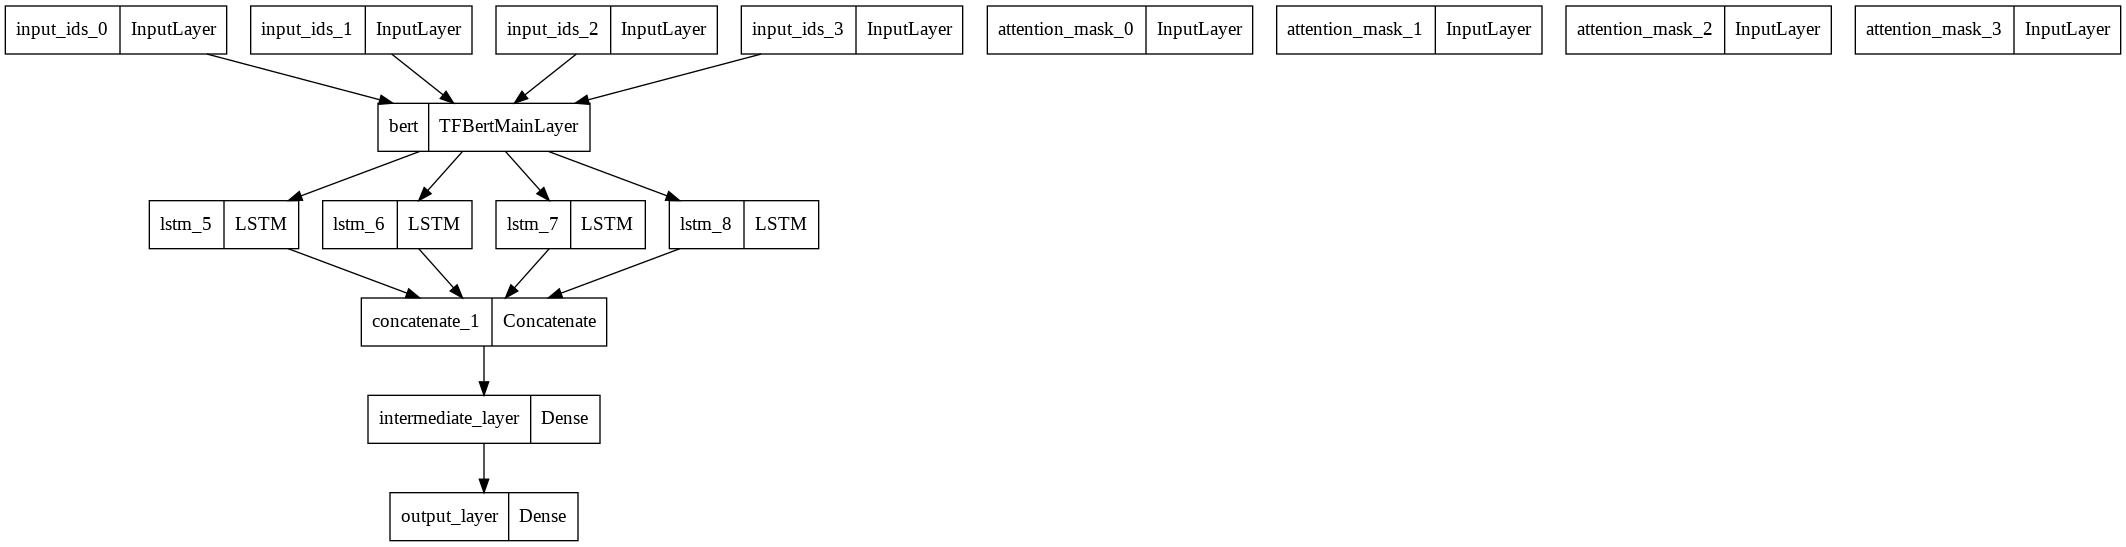

In [ ]:
import keras
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
plot_model(ddi_model_onto, to_file='/content/sample_data/ddi_model_with_onto_mltsm_.png')

In [ ]:
#@title model.complie, optimizer, loss, and accuracy metrics
#optimizer
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)

#loss function
loss_func = tf.keras.losses.CategoricalCrossentropy()

#accuracy metrics
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

ddi_model_onto.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
global F1_MACRO = 0

In [ ]:
#@title class MyCallback()
from sklearn.metrics import f1_score, precision_score
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
      keys = list(logs.keys())
      print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
      preds = ddi_model_onto.predict(test_dataset)
      y_pred = np.argmax(preds,axis=1)
      print("\nlen(y_preds) = ", len(y_pred))
      print("y_pred[0]=",y_pred[0:30])
      f1_macro = f1_score(y_pred=y_pred, y_true=y_true, average='macro')
      f1_micro = f1_score(y_pred=y_pred, y_true=y_true, average='micro')
      print("f1-score macro = ", f1_macro)
      print("f1-score micro = ", f1_micro)

      if f1_macro > F1_MACRO:
        F1_MACRO =  f1_macro
        #save_y_pred
        with open("/content/drive/MyDrive/Colab Notebooks/Bert_Sample_Data/best_y_pred_realTestData.csv") as best_y_pred_csv:
          best_y_pred_csv.write(y_pred)


      #y_tru = 
      print("End epoch {} of training; got log keys: {}".format(epoch, y_pred))

NameError: ignored

In [ ]:
#@title fit **ddi_model_onto** with train_dataset: Epoch /30 **f1= 0.75858**
model_training = ddi_model_onto.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[MyCallback()]
)

Start epoch 0 of training; got log keys: []
Epoch 1/30


1483/1483 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.9099
len(y_preds) =  5408
y_pred[0]= [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 1 2 0 0 0 3 0 0 1]
f1-score macro =  0.7288159142212696
f1-score micro =  0.9077292899408285
End epoch 0 of training; got log keys: [0 0 0 ... 0 2 2]
1483/1483 [==============================] - 1391s 910ms/step - loss: 0.2740 - accuracy: 0.9099 - val_loss: 0.1252 - val_accuracy: 0.9659
Start epoch 1 of training; got log keys: []
Epoch 2/30
1483/1483 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9610
len(y_preds) =  5408
y_pred[0]= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 2 0 0 0 3 0 0 1]
f1-score macro =  0.7276060522212516
f1-score micro =  0.9108727810650887
End epoch 1 of training; got log keys: [0 0 0 ... 0 2 2]
1483/1483 [==============================] - 1336s 901ms/step - loss: 0.1166 - accuracy: 0.9610 - val_loss: 0.0754 - val_accuracy: 0.9761
Start epoch 2 of training; got log keys: []
E

In [ ]:
#@title fit **ddi_model_onto** with train_dataset: Epoch /30 **f1= 0.725**
model_training = ddi_model_onto.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[MyCallback()]
)

Start epoch 0 of training; got log keys: []
Epoch 1/30


1483/1483 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.9065
len(y_preds) =  5408
y_pred[0]= [0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 3 2 3]
f1-score macro =  0.19784973309062887
f1-score micro =  0.6956360946745562
End epoch 0 of training; got log keys: [0 3 0 ... 0 0 0]
1483/1483 [==============================] - 1447s 947ms/step - loss: 0.2826 - accuracy: 0.9065 - val_loss: 0.1440 - val_accuracy: 0.9515
Start epoch 1 of training; got log keys: []
Epoch 2/30
1483/1483 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9588
len(y_preds) =  5408
y_pred[0]= [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0]
f1-score macro =  0.21089938524888385
f1-score micro =  0.703957100591716
End epoch 1 of training; got log keys: [0 0 2 ... 0 0 0]
1483/1483 [==============================] - 1390s 937ms/step - loss: 0.1224 - accuracy: 0.9588 - val_loss: 0.0579 - val_accuracy: 0.9803
Start epoch 2 of training; got log keys: []


KeyboardInterrupt: ignored

In [ ]:
#@title **Save model** and Checkpoints
#https://www.tensorflow.org/guide/intro_to_modules
chkp_path = "/content/drive/MyDrive/Colab Notebooks/model_/ckpoint_models/ddi_model_onto_biobert_model_rnn_with_f1_8626"
checkpoint = tf.train.Checkpoint(model=ddi_model_onto)
checkpoint.write(chkp_path)

#check variables
tf.train.list_variables(chkp_path)

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('model/layer_with_weights-0/embeddings/LayerNorm/beta/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('model/layer_with_weights-0/embeddings/LayerNorm/beta/.OPTIMIZER_SLOT/model/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('model/layer_with_weights-0/embeddings/LayerNorm/beta/.OPTIMIZER_SLOT/model/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('model/layer_with_weights-0/embeddings/LayerNorm/gamma/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('model/layer_with_weights-0/embeddings/LayerNorm/gamma/.OPTIMIZER_SLOT/model/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('model/layer_with_weights-0/embeddings/LayerNorm/gamma/.OPTIMIZER_SLOT/model/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('model/layer_with_weights-0/embeddings/embeddings/.ATTRIBUTES/VARIABLE_VALUE',
  [512, 768]),
 ('model/layer_with_weights-0/embeddings/embeddings/.OPTIMIZER_SLOT/model/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [512, 768]),
 ('model/layer_with_weight

In [ ]:
#@title **Reload** Weights from Saved Model and Checkpoints
new_model = ddi_model_onto #create model 
new_checkpoint = tf.train.Checkpoint(model=new_model)
chkp_path = "/content/drive/MyDrive/Colab Notebooks/model_/ckpoint_models_792_f1/ddi_biobert_model_all_checkpoint"

new_checkpoint.restore(chkp_path)

# Should be the same result as above
new_y_preds = new_model.predict(test_dataset)

In [ ]:
#@title **Save** ddi_model_onto as **hd5.h5**
ddi_biobert_model_hd5_path = "/content/drive/MyDrive/Colab Notebooks/model_/saved_models/ddi_model_onto_f1_8628_biobert_model_hd5.h5"
ddi_model_onto.save(ddi_biobert_model_hd5_path)

###ddi_model with lstms

In [ ]:
ddi_model = tf.keras.Model(inputs=[input_ids_0, attn_masks_0, input_ids_1, attn_masks_1, input_ids_2, attn_masks_2], outputs=output_layer)
ddi_model.summary()

In [ ]:
import keras
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
plot_model(ddi_model, to_file='/content/sample_data/ddi_model_with_hbltsm_.png')


NameError: ignored

In [ ]:
#@title model.complie, optimizer, loss, and accuracy metrics
#optimizer
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)

#loss function
loss_func = tf.keras.losses.CategoricalCrossentropy()

#accuracy metrics
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

ddi_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
#@title class MyCallback()
from sklearn.metrics import f1_score, precision_score
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
      keys = list(logs.keys())
      print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
      preds = ddi_model.predict(test_dataset)
      y_pred = np.argmax(preds,axis=1)
      print("\nlen(y_preds) = ", len(y_pred))
      print("y_pred[0]=",y_pred[0:30])
      print("f1-score macro = ", f1_score(y_pred=y_pred, y_true=y_true, average='macro'))
      print("f1-score micro = ", f1_score(y_pred=y_pred, y_true=y_true, average='micro'))

      #y_tru = 
      print("End epoch {} of training; got log keys: {}".format(epoch, y_pred))

In [ ]:
#@title fit model with train_x_data
model_training = ddi_model.fit(
    [train_X_input_ids,train_X_attn_masks,train_labels],
    #validation_data=training_dataset,#validation_dataset,
    batch_size=16,
    epochs=20,
    callbacks=[MyCallback()]
)


In [ ]:
#@title fit model with train_dataset
model_training = ddi_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[MyCallback()]
)

Start epoch 0 of training; got log keys: []
Epoch 1/30


980/980 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.8715
len(y_preds) =  7904
y_pred[0]= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
f1-score macro =  0.538221722388374
f1-score micro =  0.899671052631579
End epoch 0 of training; got log keys: [0 0 0 ... 0 0 0]
980/980 [==============================] - 885s 876ms/step - loss: 0.4159 - accuracy: 0.8715 - val_loss: 0.3702 - val_accuracy: 0.8664
Start epoch 1 of training; got log keys: []
Epoch 2/30
980/980 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9309
len(y_preds) =  7904
y_pred[0]= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
f1-score macro =  0.8050948746761304
f1-score micro =  0.9366143724696356
End epoch 1 of training; got log keys: [0 0 0 ... 0 0 0]
980/980 [==============================] - 815s 832ms/step - loss: 0.2074 - accuracy: 0.9309 - val_loss: 0.3336 - val_accuracy: 0.8854
Start epoch 2 of training; got log keys: []
Epoch 3/30
98

In [ ]:
#@title fit model with train_dataset f1= 0.7119 hblst
model_training = ddi_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[MyCallback()]
)

Start epoch 0 of training; got log keys: []
Epoch 1/30


980/980 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.8477
len(y_preds) =  7904
y_pred[0]= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
f1-score macro =  0.39250194592641297
f1-score micro =  0.8623481781376519
End epoch 0 of training; got log keys: [0 0 0 ... 0 0 0]
980/980 [==============================] - 1103s 1s/step - loss: 0.5216 - accuracy: 0.8477 - val_loss: 0.4973 - val_accuracy: 0.8441
Start epoch 1 of training; got log keys: []
Epoch 2/30
980/980 [==============================] - ETA: 0s - loss: 0.3590 - accuracy: 0.8769
len(y_preds) =  7904
y_pred[0]= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
f1-score macro =  0.5317832815455985
f1-score micro =  0.8838562753036437
End epoch 1 of training; got log keys: [0 0 0 ... 0 0 0]
980/980 [==============================] - 1105s 1s/step - loss: 0.3590 - accuracy: 0.8769 - val_loss: 0.4768 - val_accuracy: 0.8445
Start epoch 2 of training; got log keys: []
Epoch 3/30
980

In [ ]:
#@title fit model with train_dataset **best f1 = 0.843**
model_training = ddi_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[MyCallback()]
)

Start epoch 0 of training; got log keys: []
Epoch 1/20


980/980 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8717
len(y_preds) =  7904
y_pred[0]= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
f1-score macro =  0.6098761767476122
f1-score micro =  0.9095394736842105
End epoch 0 of training; got log keys: [0 0 0 ... 0 0 0]
980/980 [==============================] - 841s 828ms/step - loss: 0.4010 - accuracy: 0.8717 - val_loss: 0.3549 - val_accuracy: 0.8718
Start epoch 1 of training; got log keys: []
Epoch 2/20
980/980 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9331
len(y_preds) =  7904
y_pred[0]= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
f1-score macro =  0.815883272835373
f1-score micro =  0.9386386639676113
End epoch 1 of training; got log keys: [0 0 0 ... 0 0 0]
980/980 [==============================] - 763s 779ms/step - loss: 0.1910 - accuracy: 0.9331 - val_loss: 0.3279 - val_accuracy: 0.8843
Start epoch 2 of training; got log keys: []
Epoch 3/20
9

KeyboardInterrupt: ignored

###Save and Reload model -**Susccessfull :)** - with checkpoint method

https://www.tensorflow.org/guide/intro_to_modules

In [ ]:
#@title **Save model** and Checkpoints
#https://www.tensorflow.org/guide/intro_to_modules
chkp_path = "/content/drive/MyDrive/Colab Notebooks/model_/ckpoint_models/ddi_biobert_model_multiple_rnn"
checkpoint = tf.train.Checkpoint(model=ddi_model)
checkpoint.write(chkp_path)

#check variables
tf.train.list_variables(chkp_path)

In [ ]:
#@title **Reload** Weights from Saved Model and Checkpoints
new_model = ddi_model #create model 
new_checkpoint = tf.train.Checkpoint(model=new_model)
chkp_path = "/content/drive/MyDrive/Colab Notebooks/model_/ckpoint_models_792_f1/ddi_biobert_model_all_checkpoint"

new_checkpoint.restore(chkp_path)

# Should be the same result as above
new_y_preds = new_model.predict(test_dataset)

In [ ]:
#@title Model Performance
from sklearn.metrics import f1_score, precision_score
reload_y_preds = np.argmax(new_y_preds, axis=1)
print("f1-score macro = ", f1_score(y_pred=reload_y_preds, y_true=y_true, average='macro'))
print("f1-score micro = ", f1_score(y_pred=reload_y_preds, y_true=y_true, average='micro'))
print("percision-macro = ", precision_score(y_true=y_true, y_pred=reload_y_preds,average='macro'))
print("percision-micro = ", precision_score(y_true=y_true, y_pred=reload_y_preds,average='micro'))

f1-score macro =  0.7926971085871838
f1-score micro =  0.9302884615384615
percision-macro =  0.7854717802769401
percision-micro =  0.9302884615384616


In [ ]:
input_text = "Plenaxis [SEP] should be monitored by measuri"#"This is the best movie I have ever watched on NetFlix."#input('Input a review here:')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(ddi_model, processed_data=processed_data)
print(result)

###Save and Reload model -**Unsusccessfull :(**

In [ ]:
# Creating a SavedModel by tf.saved_model.save/load
ddi_biobert_model_all_path = "/content/drive/MyDrive/Colab Notebooks/model_/saved_models/ddi_biobert_model_all"
tf.saved_model.save(ddi_model, ddi_biobert_model_all_path)

In [ ]:
reloaded_ddi_model = tf.saved_model.load(ddi_biobert_model_all_path)
reload_preds = reloaded_ddi_model.predict(test_dataset)
reload_y_preds = np.argmax(reload_preds, axis=1)

print("f1-score macro = ", f1_score(y_pred=reload_y_preds, y_true=y_true, average='macro'))
print("f1-score micro = ", f1_score(y_pred=reload_y_preds, y_true=y_true, average='micro'))

In [ ]:
ddi_biobert_model_hd5_path = "/content/drive/MyDrive/Colab Notebooks/model_/saved_models/ddi_biobert_model_hd5.h5"
ddi_model.save(ddi_biobert_model_hd5_path)

#R-BERT


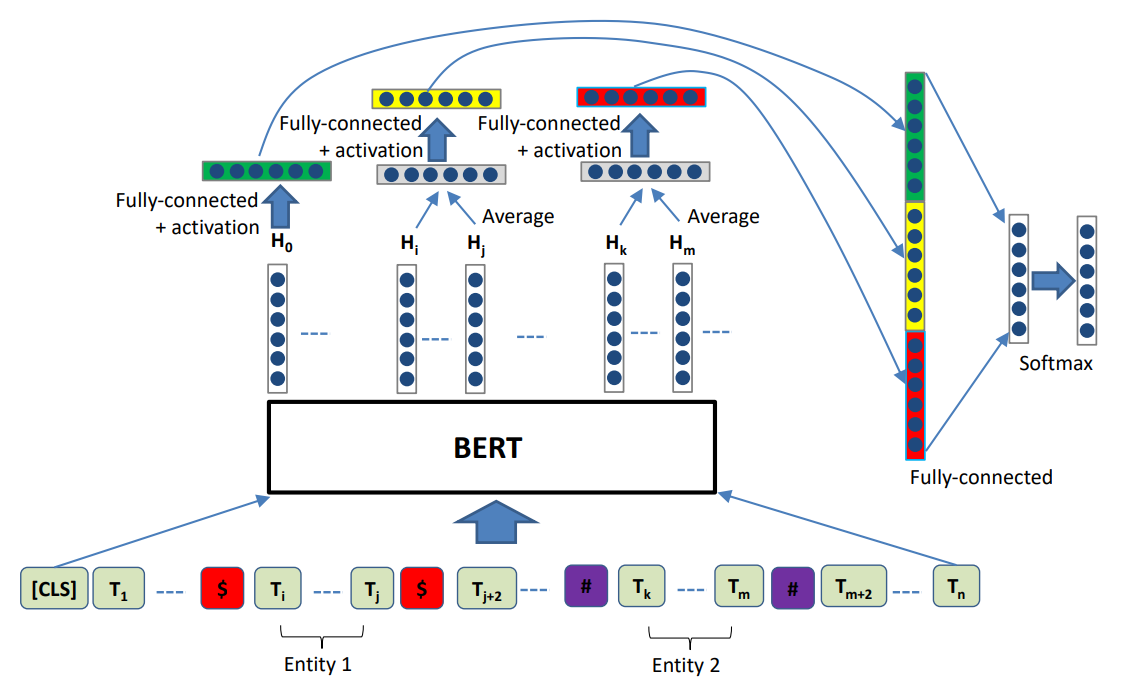

[Image ref ](https://github.com/monologg/R-BERT)

Method
1. Get three vectors from BERT.
> * [CLS] token vector
> * averaged entity_1 vector
> * averaged entity_2 vector

2. Pass each vector to the fully-connected layers.
> *   dropout -> tanh -> fc-layer
3. Concatenate three vectors.
4. Pass the concatenated vector to fully-connect layer.
> *   dropout -> fc-layer
5. Exactly the SAME conditions as written in paper.
> *   Averaging on entity_1 and entity_2 hidden state vectors, respectively. *   (including $, # tokens)
> *   Dropout and Tanh before Fully-connected layer.
> *   No [SEP] token at the end of sequence. (If you want add [SEP] token, give --add_sep_token option)

In [ ]:
from tf.keras.layers import Dense
tf.keras.layers.Dense(
    units,
    activation= "tanh",
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

##Data-Preparation- Seperated Vectores (3 Vecs)

In [ ]:
train_df["befor"] = train_df["befor"].fillna("")
train_df["after"] = train_df["after"].fillna("")
train_df["common_ascestors_ssm"] = train_df["common_ascestors_ssm"].fillna(" ")
#train_df.head(3)

In [ ]:

Number = [" #" for i in range(len(train_df))]
Number_e = ["# " for i in range(len(train_df))]

Dolar = [" $" for i in range(len(train_df))]
Dolar_e = ["$ " for i in range(len(train_df))]

SEP = [" [SEP] " for i in range(len(train_df))]
CLS = [" [CLS] " for i in range(len(train_df))]

In [ ]:
train_df["R_drugA_text"] = Number + train_df["drugA_text"] + Number_e
train_df["R_drugB_text"] = Dolar  + train_df["drugB_text"] + Dolar_e

train_df["middle"] = train_df["drugA_text"]+ SEP + train_df["middlepart"]+ SEP + train_df["drugB_text"]

train_df["R_bert"] = CLS + train_df['befor'] + train_df["R_drugA_text"]+ \
                     train_df["middlepart"] + train_df["R_drugB_text"]+ \
                     train_df["after"]

train_df["befor_Rbrt"] = CLS + train_df['befor']

train_df.head(3)

,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,...,common_ascestors_ssm,leftpath,rightpath,chebi_syns_drugA,chebi_syns_drugB,R_drugA_text,R_drugB_text,middle,R_bert,befor_Rbrt
0,false,0,Laboratory Tests Response to DRUGA_3268 should...,Plenaxis,testosterone,DRUGA_3268,DRUGB_1506,3268,1506,Laboratory Tests Response to,...,polycyclic compound organic cyclic compound cy...,"[penams, beta-lactam antibiotic, beta-lactam, ...","[testosterone, C19-steroid, 17beta-hydroxy ste...","[Eraxis, penams, Plexiglas, Levaxin, Pentasa, ...","[testosterone, TESTOSTERONE, Testosterone, Tes...",#Plenaxis#,$testosterone$,Plenaxis [SEP] should be monitored by measuri...,[CLS] Laboratory Tests Response to #Plenaxis...,[CLS] Laboratory Tests Response to
1,false,0,Population pharmacokinetic analyses revealed t...,MTX,NSAIDs,DRUGA_513,DRUGB_882,513,882,Population pharmacokinetic analyses revealed t...,...,,"[methotrexate, pteridines, dicarboxylic acid, ...","[non-steroidal anti-inflammatory drug, anti-in...","[MTX, MTX3, MT, Mt, MTX 3, MTX-3, CMX, MTT, CT...","[NSAIDs, NSAID, Ansaid, acids, enamides, ynami...",#MTX#,$NSAIDs$,"MTX [SEP] , [SEP] NSAIDs",[CLS] Population pharmacokinetic analyses rev...,[CLS] Population pharmacokinetic analyses rev...
2,false,0,Population pharmacokinetic analyses revealed t...,MTX,corticosteroids,DRUGA_513,DRUGB_2623,513,2623,Population pharmacokinetic analyses revealed t...,...,polycyclic compound organic cyclic compound cy...,"[methotrexate, pteridines, dicarboxylic acid, ...","[corticosteroid, steroid, organic polycyclic c...","[MTX, MTX3, MT, Mt, MTX 3, MTX-3, CMX, MTT, CT...","[corticosteroids, corticosteroides, corticoste...",#MTX#,$corticosteroids$,"MTX [SEP] , lactulose82 , [SEP] corticosteroids",[CLS] Population pharmacokinetic analyses rev...,[CLS] Population pharmacokinetic analyses rev...


In [ ]:
test_df["befor"] = test_df["befor"].fillna("")
test_df["after"] = test_df["after"].fillna("")
test_df["common_ascestors_ssm"] = test_df["common_ascestors_ssm"].fillna(" ")
#test_df.head(3)

In [ ]:
Number = [" #" for i in range(len(test_df))]
Number_e = ["# " for i in range(len(test_df))]

Dolar = [" $" for i in range(len(test_df))]
Dolar_e = ["$ " for i in range(len(test_df))]

SEP = [" [SEP] " for i in range(len(test_df))]
CLS = [" [CLS] " for i in range(len(test_df))]

In [ ]:
test_df["R_drugA_text"] = Number + test_df["drugA_text"] + Number_e 
test_df["R_drugB_text"] = Dolar  + test_df["drugB_text"] + Dolar_e

SEP = [" [SEP] " for i in range(len(test_df))]
test_df["middle"] = test_df["drugA_text"]+ SEP + test_df["middlepart"]+ SEP + test_df["drugB_text"]

test_df["R_bert"] = CLS + test_df['befor'] + test_df["R_drugA_text"]+ \
                     test_df["middlepart"] + test_df["R_drugB_text"] + \
                     test_df["after"]

test_df["befor_Rbrt"] = CLS + test_df['befor']

test_df.head(3)

,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,...,common_ascestors_ssm,leftpath,rightpath,chebi_syns_drugA,chebi_syns_drugB,R_drugA_text,R_drugB_text,middle,R_bert,befor_Rbrt
0,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,...,organic heterocyclic compound heterocyclic com...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a...",#abacavir#,$lamivudine$,abacavir [SEP] were not altered by the additi...,[CLS] Pharmacokinetic properties of #abacavi...,[CLS] Pharmacokinetic properties of
1,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,zidovudine,DRUGA_2289,DRUGB_2736,2289,2736,Pharmacokinetic properties of,...,heteroarene organic aromatic compound aromatic...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[zidovudine, pyrimidine 2',3'-dideoxyribonucle...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[zidovudine, Zidovudin, Zidovudinum, idoxuridi...",#abacavir#,$zidovudine$,abacavir [SEP] were not altered by the additi...,[CLS] Pharmacokinetic properties of #abacavi...,[CLS] Pharmacokinetic properties of
2,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,...,organic heterocyclic compound heterocyclic com...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a...",#abacavir#,$lamivudine$,abacavir [SEP] were not altered by the additi...,[CLS] Pharmacokinetic properties of #abacavi...,[CLS] Pharmacokinetic properties of


##Data-Preparation- Single Vector

In [ ]:
train_df["befor"] = train_df["befor"].fillna("")
train_df["after"] = train_df["after"].fillna("")
train_df["common_ascestors_ssm"] = train_df["common_ascestors_ssm"].fillna(" ")
#train_df.head(3)

In [ ]:

Number = [" #" for i in range(len(train_df))]
Number_e = ["# " for i in range(len(train_df))]

Dolar = [" $" for i in range(len(train_df))]
Dolar_e = ["$ " for i in range(len(train_df))]

SEP = [" [SEP] " for i in range(len(train_df))]
CLS = [" [CLS] " for i in range(len(train_df))]

In [ ]:

train_df["R_drugA_text"] = Number + train_df["drugA_text"] + Number_e
train_df["R_drugB_text"] = Dolar  + train_df["drugB_text"] + Dolar_e

train_df["middle"] = train_df["drugA_text"]+ SEP + train_df["middlepart"]+ SEP + train_df["drugB_text"]

train_df["R_bert"] = CLS + train_df['befor'] + train_df["R_drugA_text"]+ \
                     train_df["middlepart"] + train_df["R_drugB_text"]+ \
                     train_df["after"]


train_df.head(3)

,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,...,common_ascestors_ssm,leftpath,rightpath,chebi_syns_drugA,chebi_syns_drugB,R_drugA_text,R_drugB_text,middle,R_bert,befor_Rbrt
0,false,0,Laboratory Tests Response to DRUGA_3268 should...,Plenaxis,testosterone,DRUGA_3268,DRUGB_1506,3268,1506,Laboratory Tests Response to,...,polycyclic compound organic cyclic compound cy...,"[penams, beta-lactam antibiotic, beta-lactam, ...","[testosterone, C19-steroid, 17beta-hydroxy ste...","[Eraxis, penams, Plexiglas, Levaxin, Pentasa, ...","[testosterone, TESTOSTERONE, Testosterone, Tes...",#Plenaxis#,$testosterone$,Plenaxis [SEP] should be monitored by measuri...,[CLS] Laboratory Tests Response to #Plenaxis...,[CLS] Laboratory Tests Response to
1,false,0,Population pharmacokinetic analyses revealed t...,MTX,NSAIDs,DRUGA_513,DRUGB_882,513,882,Population pharmacokinetic analyses revealed t...,...,,"[methotrexate, pteridines, dicarboxylic acid, ...","[non-steroidal anti-inflammatory drug, anti-in...","[MTX, MTX3, MT, Mt, MTX 3, MTX-3, CMX, MTT, CT...","[NSAIDs, NSAID, Ansaid, acids, enamides, ynami...",#MTX#,$NSAIDs$,"MTX [SEP] , [SEP] NSAIDs",[CLS] Population pharmacokinetic analyses rev...,[CLS] Population pharmacokinetic analyses rev...
2,false,0,Population pharmacokinetic analyses revealed t...,MTX,corticosteroids,DRUGA_513,DRUGB_2623,513,2623,Population pharmacokinetic analyses revealed t...,...,polycyclic compound organic cyclic compound cy...,"[methotrexate, pteridines, dicarboxylic acid, ...","[corticosteroid, steroid, organic polycyclic c...","[MTX, MTX3, MT, Mt, MTX 3, MTX-3, CMX, MTT, CT...","[corticosteroids, corticosteroides, corticoste...",#MTX#,$corticosteroids$,"MTX [SEP] , lactulose82 , [SEP] corticosteroids",[CLS] Population pharmacokinetic analyses rev...,[CLS] Population pharmacokinetic analyses rev...


In [ ]:
test_df["befor"] = test_df["befor"].fillna("")
test_df["after"] = test_df["after"].fillna("")
test_df["common_ascestors_ssm"] = test_df["common_ascestors_ssm"].fillna(" ")
#test_df.head(3)

In [ ]:
Number = [" #" for i in range(len(test_df))]
Number_e = ["# " for i in range(len(test_df))]

Dolar = [" $" for i in range(len(test_df))]
Dolar_e = ["$ " for i in range(len(test_df))]

SEP = [" [SEP] " for i in range(len(test_df))]
CLS = [" [CLS] " for i in range(len(test_df))]

In [ ]:
test_df["R_drugA_text"] = Number + test_df["drugA_text"] + Number_e 
test_df["R_drugB_text"] = Dolar  + test_df["drugB_text"] + Dolar_e

SEP = [" [SEP] " for i in range(len(test_df))]
test_df["middle"] = test_df["drugA_text"]+ SEP + test_df["middlepart"]+ SEP + test_df["drugB_text"]

test_df["R_bert"] = CLS + test_df['befor'] + test_df["R_drugA_text"]+ \
                     test_df["middlepart"] + test_df["R_drugB_text"] + \
                     test_df["after"]

test_df.head(3)

,ddi,label,sentence_text,drugA_text,drugB_text,drugA,drugB,drugA_drugindex,drugB_drugindex,befor,...,common_ascestors_ssm,leftpath,rightpath,chebi_syns_drugA,chebi_syns_drugB,R_drugA_text,R_drugB_text,middle,R_bert,befor_Rbrt
0,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,...,organic heterocyclic compound heterocyclic com...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a...",#abacavir#,$lamivudine$,abacavir [SEP] were not altered by the additi...,[CLS] Pharmacokinetic properties of #abacavi...,[CLS] Pharmacokinetic properties of
1,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,zidovudine,DRUGA_2289,DRUGB_2736,2289,2736,Pharmacokinetic properties of,...,heteroarene organic aromatic compound aromatic...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[zidovudine, pyrimidine 2',3'-dideoxyribonucle...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[zidovudine, Zidovudin, Zidovudinum, idoxuridi...",#abacavir#,$zidovudine$,abacavir [SEP] were not altered by the additi...,[CLS] Pharmacokinetic properties of #abacavi...,[CLS] Pharmacokinetic properties of
2,false,0,Pharmacokinetic properties of DRUGA_2289 were ...,abacavir,lamivudine,DRUGA_2289,DRUGB_1492,2289,1492,Pharmacokinetic properties of,...,organic heterocyclic compound heterocyclic com...,"[abacavir, 2,6-diaminopurines, aminopurine, pu...","[lamivudine, nucleoside analogue, monothioacet...","[abacavir, Abacavir, 5'-oxoabacavir, Abacavir ...","[lamivudine, Lamivudine, Lamtidine, amidine, a...",#abacavir#,$lamivudine$,abacavir [SEP] were not altered by the additi...,[CLS] Pharmacokinetic properties of #abacavi...,[CLS] Pharmacokinetic properties of


##Bio-Bert Tokenizer
1. from transformers import BertModel
2. download and unzip 'biobert_v1.1_pubmed'
3. bio_model = BertModel.from_pretrained('biobert_v1.1_pubmed')

###Downloading the main BioBERT file
Here we are downloading the main BioBERT file, extracting the BioBERT weights, and converting them to be applicable in PyTorch so as to work with the HuggingFace API. We move the config file for simplicity, and now are good to go!

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt

biobert_weights     100%[===================>] 382.81M  71.5MB/s    in 6.1s    

2022-11-22 05:54:07 (62.8 MB/s) - ‘biobert_weights’ saved [401403346/401403346]



In [ ]:
!tar -xzf biobert_weights
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.index  vocab.txt
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta


In [ ]:
# conver tensorflow pretrain model to pytorch
!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

In [ ]:
!ls biobert_v1.1_pubmed/
!mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
!ls biobert_v1.1_pubmed/

In [ ]:
!ls

biobert_v1.1_pubmed  biobert_weights  drive  sample_data


###preprocess ddi dataset seperate to sentence parts#initialize these parameters:


In [ ]:
#@title İnitial inputs (train) for Bert - Seperated Vecs
X_input_ids_0 = np.zeros((len(train_df), 60))
X_attn_masks_0 = np.zeros((len(train_df), 60))

X_input_ids_1 = np.zeros((len(train_df), 100))
X_attn_masks_1 = np.zeros((len(train_df), 100))

X_input_ids_2 = np.zeros((len(train_df), 60))
X_attn_masks_2 = np.zeros((len(train_df), 60))

#entity e1
X_input_ids_e1 = np.zeros((len(train_df), 10))
X_attn_masks_e1 = np.zeros((len(train_df), 10))

#entity e2
X_input_ids_e2 = np.zeros((len(train_df), 10))
X_attn_masks_e2 = np.zeros((len(train_df), 10))

labels_r = np.zeros((len(train_df), 5))

#ontology channel inputs
X_input_ids_3 = np.zeros((len(train_df), 100))
X_attn_masks_3 = np.zeros((len(train_df), 100))

print("labels_r.shape=",labels_r.shape)
print("X_input_ids_1.shape=",X_input_ids_1.shape)
print(X_input_ids_1[0])

print("X_input_ids_0.shape=",X_input_ids_0.shape)
print(X_input_ids_0[0])
print("X_input_ids_3.shape=",X_input_ids_3.shape)
print(X_input_ids_3[0])

labels_r.shape= (26383, 5)
X_input_ids_1.shape= (26383, 100)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
X_input_ids_0.shape= (26383, 60)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X_input_ids_3.shape= (26383, 100)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
#@title Performing one-hot encoding for labeles
labels_r[np.arange(len(train_df)), list(train_df['label'])]
y = list(train_df['label'])
labels_r = tf.keras.utils.to_categorical(y , num_classes=5, dtype='float32')
labels_r

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
def remove_CLS_SLP_from_parts(input_ids, attn_mask):
  import numpy as np
  
  print("input_ids= ",input_ids)
  print("attn_mask= ", attn_mask)

  nparray_ids = np.array(input_ids)
  nparray_attns = np.array(attn_mask)

  cls_ind = np.where(nparray_ids==101)[0][0] # only first cls
  slp_ind = np.where(nparray_ids==102)[0][-1] # only last slp

  print("cls_ind= ",cls_ind)
  print("slp_ind= ",slp_ind)

  nparray_attns[cls_ind] = 0 # remove first 101
  nparray_attns[slp_ind] = 0 #remove last slp

  nparray_attns_t = tf.convert_to_tensor([nparray_attns], np.int32)
  print("nparray_attns_t= ", nparray_attns_t)
  return nparray_attns



In [ ]:
#@title preprocessing_dataset_R()
def preprocessing_dataset_R(df, ids, masks, tokenizer, sen_part='middlepart'):
    #X_e1_masks_r, X_e2_masks_r = e_masks
    #print("X_e1_masks_r.shape=",X_e1_masks_r.shape)
    if sen_part == "common_ascestors_ssm" or sen_part == "middlepart":
      max_length_= 100
    else:
      max_length_= 60
    
    for i, text in tqdm(enumerate(df[sen_part])):
      tokenized_text = tokenizer.encode_plus(
          text,
          max_length=max_length_,      
          truncation=True, 
          padding='max_length', 
          add_special_tokens=True,
          return_tensors='tf'
          )
      
      # 0th dim of tokenized_text.input_ids[0] is a numpy array of the tokens-ids
      #e_mask_e1, e_mask_e2 = compute_entities_masks((X_e1_masks_r[i], X_e2_masks_r[i]) , tokenized_text.input_ids[0]) 
      
      attn_mask = remove_CLS_SLP_from_parts(tokenized_text.input_ids[0], tokenized_text.attention_mask[0])
      
      ids[i, :] = tokenized_text.input_ids
      masks[i, :] = attn_mask  #tokenized_text.attention_mask

      #X_e1_masks_r [i, :] = e_mask_e1
      #X_e2_masks_r [i, :] = e_mask_e2

      tokens= tokenizer.tokenize(text) # for print only
      print("len(tokens)=",len(tokens))
      if i==0:
        print("len(text) = ", len(text.split(" ")))
      
        print("text=",text)
        
        print("len(tokens)=",len(tokens))
        print("tokens=",tokens)
        print("len_tokenized_text= ",len(tokenized_text))
        print("tokenized_text= ",tokenized_text) 
        break
     
    return ids, masks#, e_masks

In [ ]:
#@title preprocessing_dataset_entities_R()
def preprocessing_dataset_entities_R(df, ids, e_masks, tokenizer, sen_part='R_drugA_text'):
    #X_e1_masks_r, X_e2_masks_r = e_masks
    #print("X_e1_masks_r.shape=",X_e1_masks_r.shape)
    max_length_= 10
    
    for i, text in tqdm(enumerate(df[sen_part])):
      tokenized_text = tokenizer.encode_plus(
          text,
          max_length=max_length_,      
          truncation=True, 
          padding='max_length', 
          add_special_tokens=True,
          return_tensors='tf'
          )
      
      # 0th dim of tokenized_text.input_ids[0] is a numpy array of the tokens-ids
      #e_mask_e1, e_mask_e2 = compute_entities_masks((X_e1_masks_r[i], X_e2_masks_r[i]) , tokenized_text.input_ids[0]) 
      
      attn_mask = remove_CLS_SLP_from_parts(tokenized_text.input_ids[0], tokenized_text.attention_mask[0]) 
      
      ids[i, :] = tokenized_text.input_ids
      e_masks[i, :] = attn_mask  #tokenized_text.attention_mask

      print("ids[i, :]=", ids[i, :])
      print(" e_masks[i, :]= ",  e_masks[i, :])

      #X_e1_masks_r [i, :] = e_mask_e1
      #X_e2_masks_r [i, :] = e_mask_e2

      tokens= tokenizer.tokenize(text) # for print only
      print("len(tokens)=",len(tokens))
      if i==0:
        print("len(text) = ", len(text.split(" ")))
    
        print("text=",text)
        
        print("len(tokens)=",len(tokens))
        print("tokens=",tokens)
        print("len_tokenized_text= ",len(tokenized_text))
        print("tokenized_text= ",tokenized_text) 
        break
     
    return ids, e_masks#, e_masks

In [ ]:
#@title Bio-Bert Tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed')

In [ ]:
# Before channel with "[CLS]" 
X_input_ids_0, X_attn_masks_0 = preprocessing_dataset_R( train_df, X_input_ids_0, X_attn_masks_0, tokenizer, sen_part='befor_Rbrt')

0it [00:00, ?it/s]

input_ids=  tf.Tensor(
[ 101  101 8087 5715 2593 1106  102    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(60,), dtype=int32)
attn_mask=  tf.Tensor(
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(60,), dtype=int32)
cls_ind=  0
slp_ind=  6
nparray_attns_t=  tf.Tensor(
[[0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 60), dtype=int32)
len(tokens)= 5
len(text) =  7
text=  [CLS] Laboratory Tests Response to 
len(tokens)= 5
tokens= ['[CLS]', 'laboratory', 'tests', 'response', 'to']
len_tokenized_text=  3
tokenized_text=  {'input_ids': <tf.Tensor: shape=(1, 60), dtype=int32, numpy=
array([[ 101,  

In [ ]:
# midlle channel 
X_input_ids_1, X_attn_masks_1 = preprocessing_dataset_R( train_df, X_input_ids_1, X_attn_masks_1, tokenizer, sen_part='middlepart')# "middlepart" is row midle part of the senteces but "midlle" is sorunded with "[SLP]" that we dont want to use it here 

0it [00:00, ?it/s]

len(tokens)= 7
len(text) =  9
text=  should be monitored by measuring serum total 
len(tokens)= 7
tokens= ['should', 'be', 'monitored', 'by', 'measuring', 'serum', 'total']
len_tokenized_text=  3
tokenized_text=  {'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  101,  1431,  1129, 19232,  1118, 10099, 23651,  1703,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [ ]:
#after-channel 
X_input_ids_2, X_attn_masks_2 = preprocessing_dataset_R( train_df, X_input_ids_2, X_attn_masks_2, tokenizer, sen_part='after')

0it [00:00, ?it/s]

len(tokens)= 16
len(text) =  15
text=  concentrations just prior to administration on Day dg and every dg weeks thereafter .
len(tokens)= 16
tokens= ['concentrations', 'just', 'prior', 'to', 'administration', 'on', 'day', 'd', '##g', 'and', 'every', 'd', '##g', 'weeks', 'thereafter', '.']
len_tokenized_text=  3
tokenized_text=  {'input_ids': <tf.Tensor: shape=(1, 60), dtype=int32, numpy=
array([[  101, 14759,  1198,  2988,  1106,  3469,  1113,  1285,   173,
         1403,  1105,  1451,   173,  1403,  2277,  7321,   119,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 60), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# ontology channel
X_input_ids_3, X_attn_masks_3 = preprocessing_dataset_R( train_df, X_input_ids_3, X_attn_masks_3, tokenizer, sen_part='common_ascestors_ssm') 

In [ ]:
#DrugA channel
X_input_ids_e1, X_attn_masks_e1 = preprocessing_dataset_entities_R( train_df, X_input_ids_e1, X_attn_masks_e1, tokenizer, sen_part='R_drugA_text')

0it [00:00, ?it/s]

input_ids=  tf.Tensor([  101   108   185 23675  8745  1116   108   102     0     0], shape=(10,), dtype=int32)
attn_mask=  tf.Tensor([1 1 1 1 1 1 1 1 0 0], shape=(10,), dtype=int32)
cls_ind=  0
slp_ind=  7
nparray_attns_t=  tf.Tensor([[0 1 1 1 1 1 1 0 0 0]], shape=(1, 10), dtype=int32)
ids[i, :]= [  101.   108.   185. 23675.  8745.  1116.   108.   102.     0.     0.]
 e_masks[i, :]=  [0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
len(tokens)= 6
len(text) =  3
text=  #Plenaxis# 
len(tokens)= 6
tokens= ['#', 'p', '##lena', '##xi', '##s', '#']
len_tokenized_text=  3
tokenized_text=  {'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  101,   108,   185, 23675,  8745,  1116,   108,   102,     0,
            0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=int32)>}


In [ ]:
#DrugB channel
X_input_ids_e2, X_attn_masks_e2 = preprocessing_dataset_entities_R( train_df, X_input_ids_e2, X_attn_masks_e2, tokenizer, sen_part='R_drugB_text')

0it [00:00, ?it/s]

len(tokens)= 4
len(text) =  3
text=  $testosterone$ 
len(tokens)= 4
tokens= ['$', 'test', '##osterone', '$']
len_tokenized_text=  3
tokenized_text=  {'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  101,   109,  2774, 26622,   109,   102,     0,     0,     0,
            0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], dtype=int32)>}


## **TODO: NOTE!!!** chon len_sent bad az tokenization moshkel peida mikonad - **Problem for long sentences** and **Long Midle Parts** 
hatta az 1000 ham bozorgtar shod
behtar ast bejaye kole jomle az 3 ghesmati estefadeh konam va tak tak tokenize konam ke betunam max_len bezaram .....
ino bayad dar sotun R_bert dorost konam ya oono replace konam 
injuri nemishe .....


In [ ]:
#@title İnitial inputs for R-Bert (3x60 + 1cpl+ 2e1 +2e2) - **OLD?**

X_input_ids_r = np.zeros((len(train_df), 1000))
X_attn_masks_r = np.zeros((len(train_df), 1000))

#ontology channel inputs
X_input_ids_o = np.zeros((len(train_df), 90))
X_attn_masks_o = np.zeros((len(train_df), 90))

#label
labels_r = np.zeros((len(train_df), 5))

print("labels_r.shape=",labels_r.shape)
print("X_input_ids_r.shape=",X_input_ids_r.shape)
print(X_input_ids_r[0])

print("X_attn_masks_r.shape=",X_attn_masks_r.shape)
print(X_attn_masks_r[0])

In [ ]:
# enities masks
X_e1_masks_r = np.zeros((len(train_df), 1000))
X_e2_masks_r = np.zeros((len(train_df), 1000))
train_entities_masks = (X_e1_masks_r, X_e2_masks_r)

print(X_e1_masks_r.shape)

(26383, 1000)


In [ ]:
#@title Performing one-hot encoding
labels_r[np.arange(len(train_df)), list(train_df['label'])]
y = list(train_df['label'])
labels_r = tf.keras.utils.to_categorical(y , num_classes=5, dtype='float32')
labels_r

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
def compute_entities_masks(e_i_masks , token_ids):
  """
  This method takes initilized masking vector of e1 and e2 entities
  """
  #print("e_masks[0].shape=",e_i_masks[0].shape)
  e1_mask_r, e2_mask_r = e_i_masks
  nparray = np.array(token_ids)
  try:
    e1_strat , e1_end = np.where(nparray==108)[0]# 108 is bert tokenized id fo "#"; #e1#
    e2_strat , e2_end = np.where(nparray==109)[0]# 109 is bert tokenized id fo "$"; $e2$
  except:
    #print("e2_strat", e2_strat)
    print(token_ids)


  
  #print("e1_strat, e1_end = ", e1_strat, e1_end)
  #print("e2_strat, e2_end = ", e2_strat, e2_end)

  for i in range (e1_strat , e1_end+1):
    e1_mask_r[i] = 1
  #print("e1_mask_r=",e1_mask_r)
  for i in range (e2_strat , e2_end+1):
    e2_mask_r[i] = 1
  return (e1_mask_r, e2_mask_r)

In [ ]:
def preprocessing_dataset_R(df, ids, masks, e_masks, tokenizer,sen_part='middle'):
    X_e1_masks_r, X_e2_masks_r = e_masks
    #print("X_e1_masks_r.shape=",X_e1_masks_r.shape)
    if sen_part == "common_ascestors_ssm":
      max_length_= 90
    else:
      max_length_= 1000
    
    for i, text in tqdm(enumerate(df[sen_part])):
      tokenized_text = tokenizer.encode_plus(
          text,
          max_length=max_length_,      
          truncation=True, 
          padding='max_length', 
          add_special_tokens=True,
          return_tensors='tf'
          )
      
      # 0th dim of tokenized_text.input_ids[0] is a numpy array of the tokens-ids
      e_mask_e1, e_mask_e2 = compute_entities_masks((X_e1_masks_r[i], X_e2_masks_r[i]) , tokenized_text.input_ids[0]) 

      ids[i, :] = tokenized_text.input_ids
      masks[i, :] = tokenized_text.attention_mask

      X_e1_masks_r [i, :] = e_mask_e1
      X_e2_masks_r [i, :] = e_mask_e2

      tokens= tokenizer.tokenize(text) # for print only
      print("len(tokens)=",len(tokens))
      if i==0:
        print("len(text) = ", len(text.split(" ")))
      
        print("text=",text)
        
        print("len(tokens)=",len(tokens))
        print("tokens=",tokens)
        print("len_tokenized_text= ",len(tokenized_text))
        print("tokenized_text= ",tokenized_text) 
        #break
     
    return ids, masks, e_masks

In [ ]:
#@title Bio-Bert Tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed')

In [ ]:
#@title Örnek Cell - Can remove...
prompt = "that's #great_idea#, fucking $man$."
next_sentence = "that is $great$"

encoding = tokenizer(prompt, next_sentence, return_tensors='pt')
print(encoding)
nparray = np.array(encoding.input_ids[0])
strat , end = np.where(nparray==108)[0] 
print(strat, end)


print(np.where(nparray==109)[0] )


{'input_ids': tensor([[ 101, 1115,  112,  188,  108, 1632,  168, 1911,  108,  117, 8750,  109,
         1299,  109,  119,  102, 1115, 1110,  109, 1632,  109,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
4 8
[11 13 18 20]


In [ ]:
#@title Örnek Cell - Can remove...

print(tokenizer.tokenize(prompt))
tokenized_text = tokenizer.encode_plus(
          prompt,
          max_length=15,      
          truncation=True, 
          padding='max_length', 
          add_special_tokens=True,
          return_tensors='tf'
          )

nparray = np.array(tokenized_text.input_ids)[0]
print(nparray)
e1_strat , e1_end = np.where(nparray==108)[0] # tokenized_id of  "#"
e2_strat , e2_end = np.where(nparray==109)[0] # tokenized_id of  "$"

print(e1_strat, e1_end)
print(e2_strat, e2_end)
for i in range(len(e_masks))

['that', "'", 's', '#', 'great', '_', 'idea', '#', ',', 'fucking', '$', 'man', '$', '.']
[ 101 1115  112  188  108 1632  168 1911  108  117 8750  109 1299  109
  102]
4 8
11 13


In [ ]:
X_input_ids_r, X_attn_masks_r, train_entities_masks = preprocessing_dataset_R( 
                                                                              train_df, 
                                                                              X_input_ids_r,
                                                                              X_attn_masks_r,
                                                                              train_entities_masks,
                                                                              tokenizer, 
                                                                              sen_part='R_bert'
                                                                              )

0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
len(tokens)= 85
len(tokens)= 86
len(tokens)= 80
len(tokens)= 91
len(tokens)= 87
len(tokens)= 88
len(tokens)= 82
len(tokens)= 97
len(tokens)= 98
len(tokens)= 92
len(tokens)= 94
len(tokens)= 88
len(tokens)= 89
len(tokens)= 103
len(tokens)= 115
len(tokens)= 103
len(tokens)= 103
len(tokens)= 110
len(tokens)= 110
len(tokens)= 110
len(tokens)= 17
len(tokens)= 39
len(tokens)= 30
len(tokens)= 38
len(tokens)= 125
len(tokens)= 129
len(tokens)= 120
len(tokens)= 125
len(tokens)= 127
len(tokens)= 134
len(tokens)= 129
len(tokens)= 120
len(tokens)= 129
len(tokens)= 130
len(tokens)= 120
len(tokens)= 124
len(tokens)= 115
len(tokens)= 120
len(tokens)= 122
len(tokens)= 129
len(tokens)= 124
len(tokens)= 115
len(tokens)= 124
len(tokens)= 125
len(tokens)= 115
len(tokens)= 119
len(tokens)= 124
len(tokens)= 126
len(tokens)= 133
len(tokens)= 128
len(tokens)= 119
len(tokens)= 128
len(tokens)= 129
len(tokens)= 119
len(tokens)= 115
len(tokens)= 117
len(tokens)= 1

UnboundLocalError: ignored

In [ ]:
#ontology path input
X_input_ids_o, X_attn_masks_o = preprocessing_dataset(train_df, X_input_ids_o, X_attn_masks_o, tokenizer,sen_part='common_ascestors_ssm')#path_part='common_ascestors_ssm')

0it [00:00, ?it/s]

In [ ]:
#@title **test inputs**
X_test_input_ids_r = np.zeros((len(test_df), 182))
X_test_attn_masks_r = np.zeros((len(test_df), 182))

#ontology channel inputs
X_test_input_ids_o = np.zeros((len(test_df), 60))
X_test_attn_masks_o = np.zeros((len(test_df), 60))

#label
test_labels_r = np.zeros((len(test_df), 5))

print("test_labels.shape=",test_labels.shape)
print("X_test_input_ids_r.shape=",X_test_input_ids_r.shape)
print(X_test_input_ids_r[0])

print("X_test_input_ids_o.shape=",X_test_input_ids_o.shape)
print(X_test_input_ids_o[0])

test_labels.shape= (5415, 5)
X_test_input_ids_r.shape= (5415, 182)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X_test_input_ids_o.shape= (5415, 60)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
#@title Performing one-hot encoding - **test_labels**
test_labels_r[np.arange(len(test_df)), list(test_df['label'])]
test_y = list(test_df['label'])
test_labels_r = tf.keras.utils.to_categorical(test_y , num_classes=5, dtype='float32')
test_labels_r

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
X_test_input_ids_r, X_test_attn_masks_R = preprocessing_dataset(test_df, X_test_input_ids_r, X_test_attn_masks_r, tokenizer, sen_part='R_bert')

NameError: ignored

In [ ]:
X_test_input_ids_o, X_test_attn_masks_o = preprocessing_dataset_R(test_df, X_test_input_ids_o, X_test_attn_masks_o, tokenizer, sen_part='common_ascestors_ssm')

##R-BERT Model

In [ ]:
##@title  Adding the Input layers
input_ids_0 = tf.keras.layers.Input(shape=(60,), name='input_ids_0', dtype='int32')
attn_masks_0 = tf.keras.layers.Input(shape=(60,), name='attention_mask_0', dtype='int32')

input_ids_1 = tf.keras.layers.Input(shape=(60,), name='input_ids_1', dtype='int32')
attn_masks_1 = tf.keras.layers.Input(shape=(60,), name='attention_mask_1', dtype='int32')

input_ids_2 = tf.keras.layers.Input(shape=(60,), name='input_ids_2', dtype='int32')
attn_masks_2 = tf.keras.layers.Input(shape=(60,), name='attention_mask_2', dtype='int32')


#Ontology
input_ids_3 = tf.keras.layers.Input(shape=(60,), name='input_ids_3', dtype='int32')
attn_masks_3 = tf.keras.layers.Input(shape=(60,), name='attention_mask_3', dtype='int32')

In [ ]:
#R-BERT layer
#bert_embds = bio_model.bert(input_ids, attention_mask=attn_masks)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

bert_hidden_state_0 = bio_model.bert(input_ids_0, attention_mask=attn_masks_0)[0]
bert_hidden_state_1 = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[0]
bert_hidden_state_2 = bio_model.bert(input_ids_2, attention_mask=attn_masks_2)[0]

#ontology 
bert_hidden_state_3 = bio_model.bert(input_ids_3, attention_mask=attn_masks_3)[0]
#-----
bert_embds = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

#Fully-Connected_Layers (Dense Layers)
#dense_e0_average()
#dense_e1_average()
dense_0 = tf.keras.layers.Dense(768, activation= "tanh", dropout=0.1)(bert_hidden_state_0)
dense_1 = tf.keras.layers.Dense(768, activation= "tanh", dropout=0.1)(bert_hidden_state_1)
dense_2 = tf.keras.layers.Dense(768, activation= "tanh", dropout=0.1)(bert_hidden_state_2)

#Last-Fully-Connected_Layers (Dense Layers)
concatenate_layer = tf.keras.layers.concatenate([lstm_0, lstm_1, lstm_2, lstm_onto], axis=1)
intermediate_layer = tf.keras.layers.Dense(786, activation='relu', name='intermediate_layer')(concatenate_layer)#512

In [ ]:
#@title with **LSTMs and Ontology** 

#bio-bert layer
#bert_embds = bio_model.bert(input_ids, attention_mask=attn_masks)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

bert_hidden_state_0 = bio_model.bert(input_ids_0, attention_mask=attn_masks_0)[0]
bert_hidden_state_1 = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[0]
bert_hidden_state_2 = bio_model.bert(input_ids_2, attention_mask=attn_masks_2)[0]

#ontology 
bert_hidden_state_3 = bio_model.bert(input_ids_3, attention_mask=attn_masks_3)[0]
#-----
bert_embds = bio_model.bert(input_ids_1, attention_mask=attn_masks_1)[1]# bert model do ta khoruji dasht= hidden-state, Sequence 

#LSTMs

lstm_0 = tf.keras.layers.LSTM(768,  dropout=0.25)(bert_hidden_state_0)
lstm_1 = tf.keras.layers.LSTM(768,  dropout=0.25)(bert_hidden_state_1)
lstm_2 = tf.keras.layers.LSTM(768,  dropout=0.25)(bert_hidden_state_2)

lstm_onto = tf.keras.layers.LSTM(768,  dropout=0.25)(bert_hidden_state_3)
print(lstm_onto)
concatenate_layer = tf.keras.layers.concatenate([lstm_0, lstm_1, lstm_2, lstm_onto], axis=1)
print(concatenate_layer.shape)
#intermediate_layer
intermediate_layer = tf.keras.layers.Dense(786, activation='relu', name='intermediate_layer')(concatenate_layer)#512

"""
#BLSTMs
blstm_0 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_0)
blstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_1)
blstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True, dropout=0.2))(bert_hidden_state_2)

concatenate_layer = tf.keras.layers.concatenate([blstm_0, blstm_1, blstm_2], axis=1)
print(concatenate_layer.shape)


blstm_l2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768,  dropout=0.2))(concatenate_layer)#(blstm_1)###(100, return_sequences=True, dropout=0.2)(bert_hidden_state_1)
#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(blstm_l2)#(concatenate_layer)#(lstm_1)#(bert_embds)
"""

#https://datascience.stackexchange.com/questions/76444/how-can-i-build-a-self-attention-model-with-tf-keras-layers-attention
#attention = tf.keras.layers.Attention(use_scale=True)(lstm_1, lstm_1)#  use_scale=True arg: that is a scaling of the self-attention tensor


#output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) 

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='lstm_8/PartitionedCall:0', description="created by layer 'lstm_8'")
(None, 3072)


#Sentiment-Model

###Sentiment Analysis Dataset

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bert_Sample_Data/sentiment_train.tsv', sep='\t')
print(len(df))
df.head(3)

156060


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2


###X_input_ids 

In [ ]:
#initialize these parameters:

X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

##Model creation

###Bert Model Creation

In [ ]:
from transformers import TFBertModel

In [ ]:
model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


###Adding the layers

The layer will be named "input_ids", and it will have **256** neurons because this is the **maximum length of the input Ids**.

In [ ]:
#@title Adding input layers and Attention Mask
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')

attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

In [ ]:
#@title **bert_embds** : Combine input layers and Attention Mask layers and **feed them the BERT model**
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1]

In [ ]:
#@title Intermediate and output layers
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) 

In [ ]:
#@title Default sentiment_model
sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

###Bert Tokenizer
'bert-base-cased'

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

##Preprocessing the sentiment analysis dataset

The sentences in the sentences (phrase) column have varying lengths, so the BertTokenizer synthesizes new tokens to ensure the lengths of sentences are uniform.

In [ ]:
#initialize these parameters:

X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

We generate the tokens from the df 

in "preprocessing_dataset()" function,


*  return_tensors='tf: ensures that the function outputs the preprocessed text as TensorFlow tensors.

In [ ]:
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Phrase'])):
        tokenized_text = tokenizer.encode_plus( # "tokenizer.encode_plus()" is used...
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = preprocessing_dataset(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
#@title Create labels
labels = np.zeros((len(df), 5))
labels.shape

(156060, 5)

In [ ]:
#@title Performing one-hot encoding - It was possible to leverage "tocathegorical()" function
labels[np.arange(len(df)), df['Sentiment'].values]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
#@title Create batches of data
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

In [ ]:
#@title Creating a map function
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction)

In [ ]:
#@title Shuffling the training dataset
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) 

In [ ]:
#@title train-test dataset spilint (20% for test)
p = 0.8
train_size = int((len(df)//16)*p)

training_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

##Model creation

###Bert model from **'bert-base-cased'**

In [ ]:
from transformers import TFBertModel

In [ ]:
model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


###Adding the layers

The layer will be named "input_ids", and it will have **256** neurons because this is the **maximum length of the input Ids**.

In [ ]:
#@title Adding input layers and Attention Mask
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')

attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

In [ ]:
#@title **bert_embds** : Combine input layers and Attention Mask layers and **feed them the BERT model**
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1]

In [ ]:
#@title Intermediate and output layers
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) 

In [ ]:
#@title Default sentiment_model
sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
#@title optimizers, loss, and accurac metrics
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
#@title Compiling the initialized neural network
sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
model_training = sentiment_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=2
)

In [ ]:
input_text = "This is the best movie I have ever watched on NetFlix."#input('Input a review here:')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(sentiment_model, processed_data=processed_data)
print(f"Classification results: {result}")